<a href="https://colab.research.google.com/github/Onyimatics/diabetes_prediction_deep_neural_network/blob/master/Diabetes_Prediction_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-tuner # Install the keras-tuner package using pip.
!pip install bayesian-optimization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.6 MB/s eta 0:00:00


In [ ]:
## Importing the libraries needed for collecting data and for analysis
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from scipy import stats

import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# build the neural network using keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Nadam, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.initializers import HeUniform
from sklearn.metrics import classification_report, confusion_matrix
import random
import os

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)

In [ ]:
# Load datasets
train_df = pd.read_csv('https://drive.google.com/uc?export=download&id=1M4MTBKUaR4aA8hjINEGhfShBZ18ctZA-')
test_df = pd.read_csv('https://drive.google.com/uc?export=download&id=1BhfC5yBThGkAdkxbf7kEVZFjsysVYXqP')

In [ ]:
train_df.head()

,id,A1,A2,A3,A4,A5,A6,A7,A8,class
0,1,6,148,72,35,0,33.6,0.627,50,1
1,2,1,85,66,29,0,26.6,0.351,31,0
2,3,8,183,64,0,0,23.3,0.672,32,1
3,4,1,89,66,23,94,28.1,0.167,21,0
4,5,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
train_df.isnull().sum()

,0
id,0
A1,0
A2,0
A3,0
A4,0
A5,0
A6,0
A7,0
A8,0
class,0


##EDA

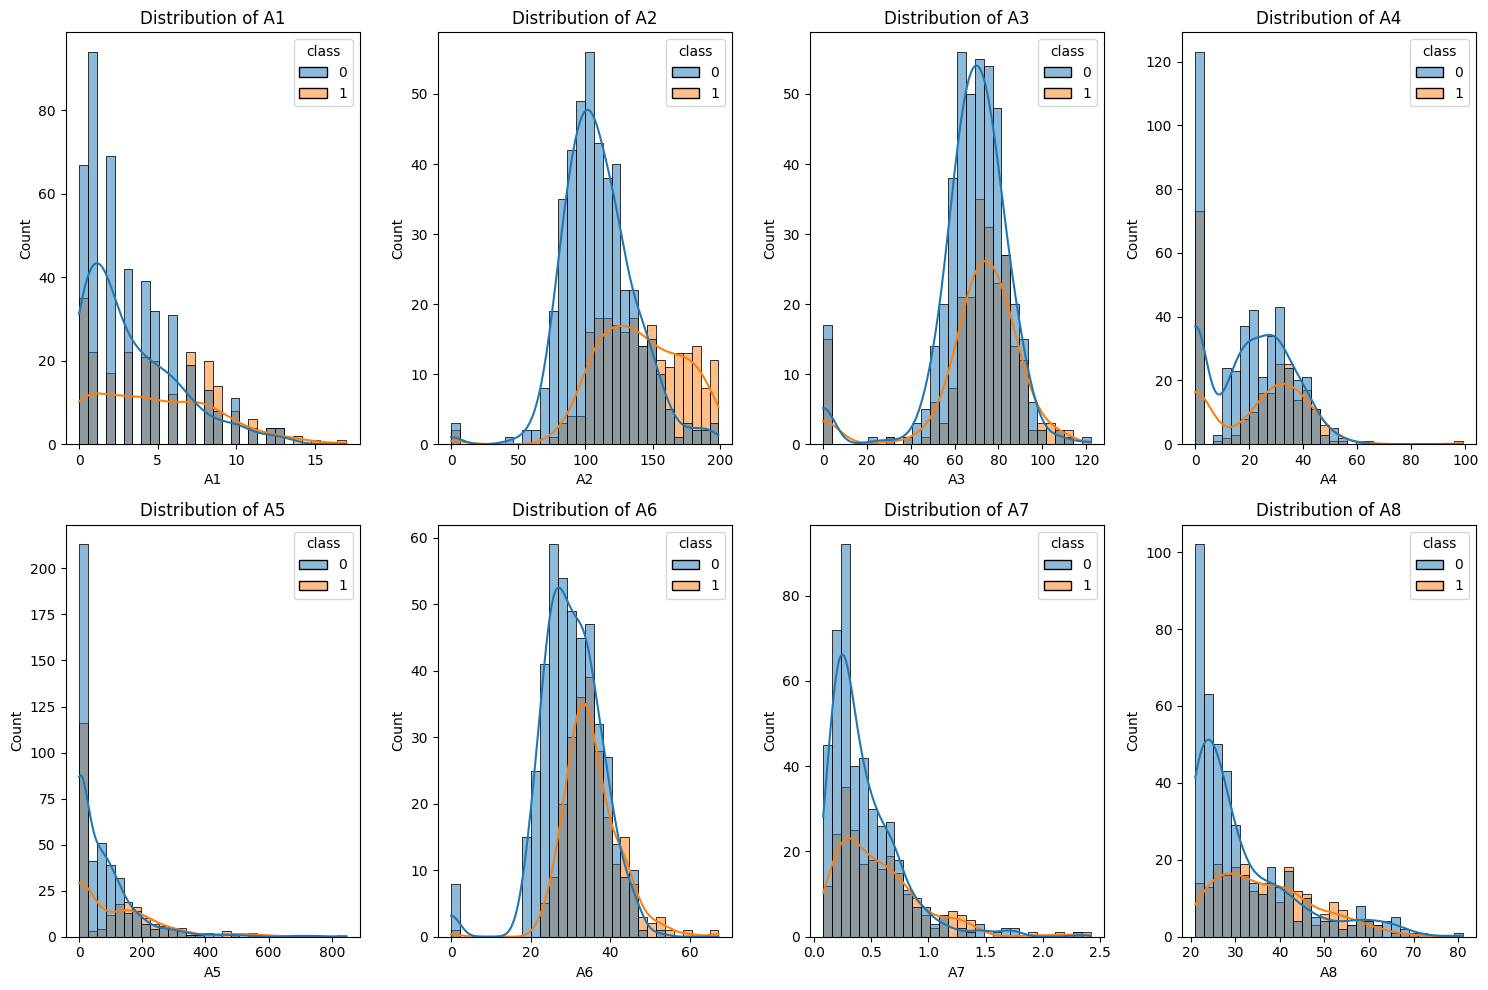

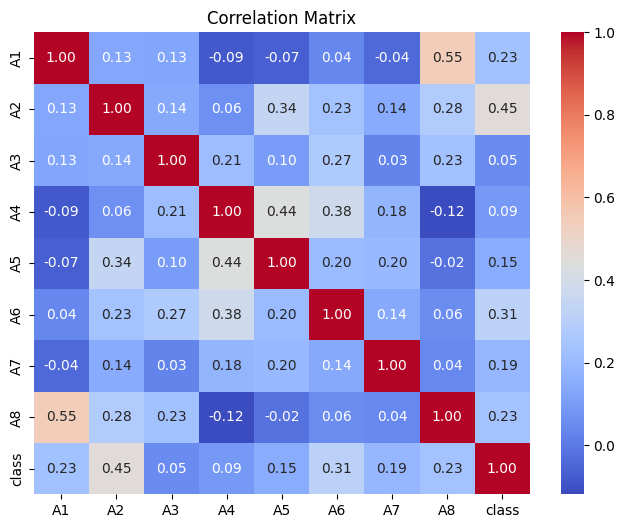

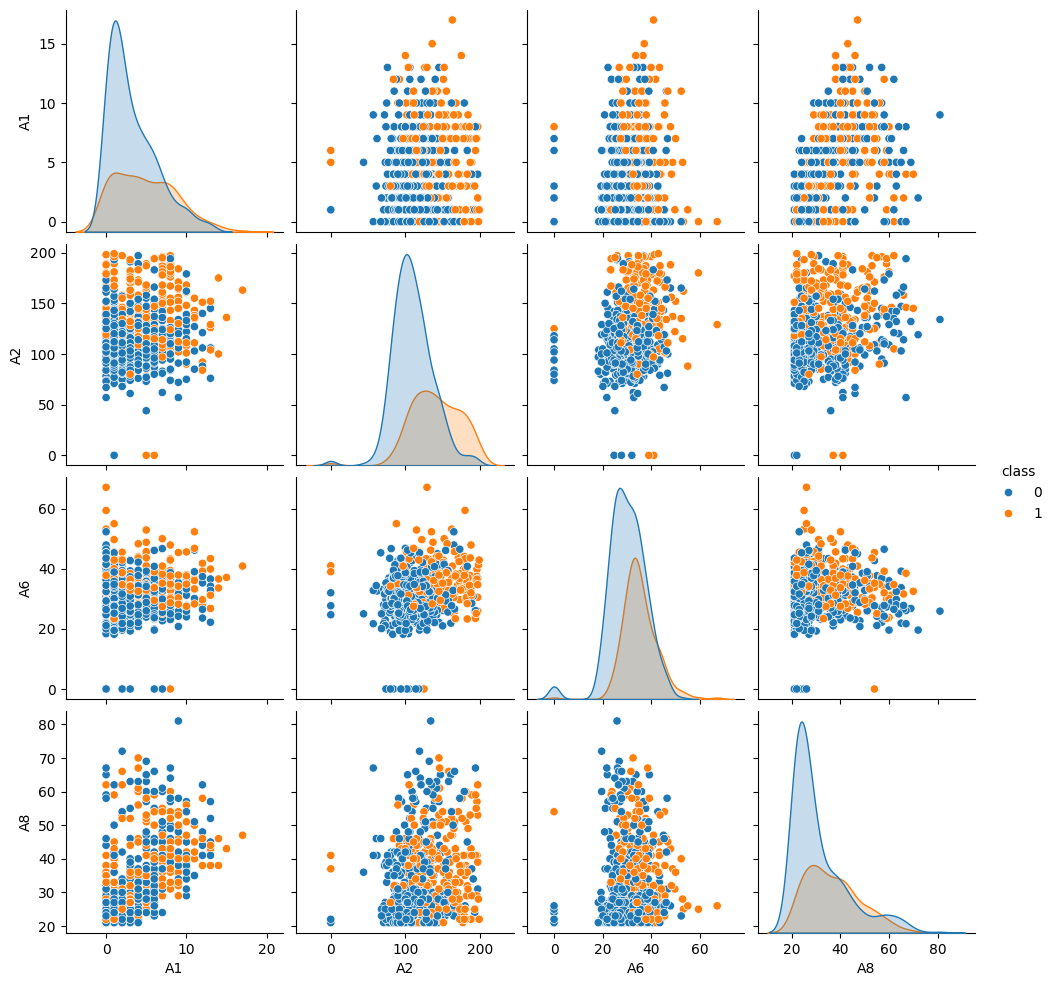

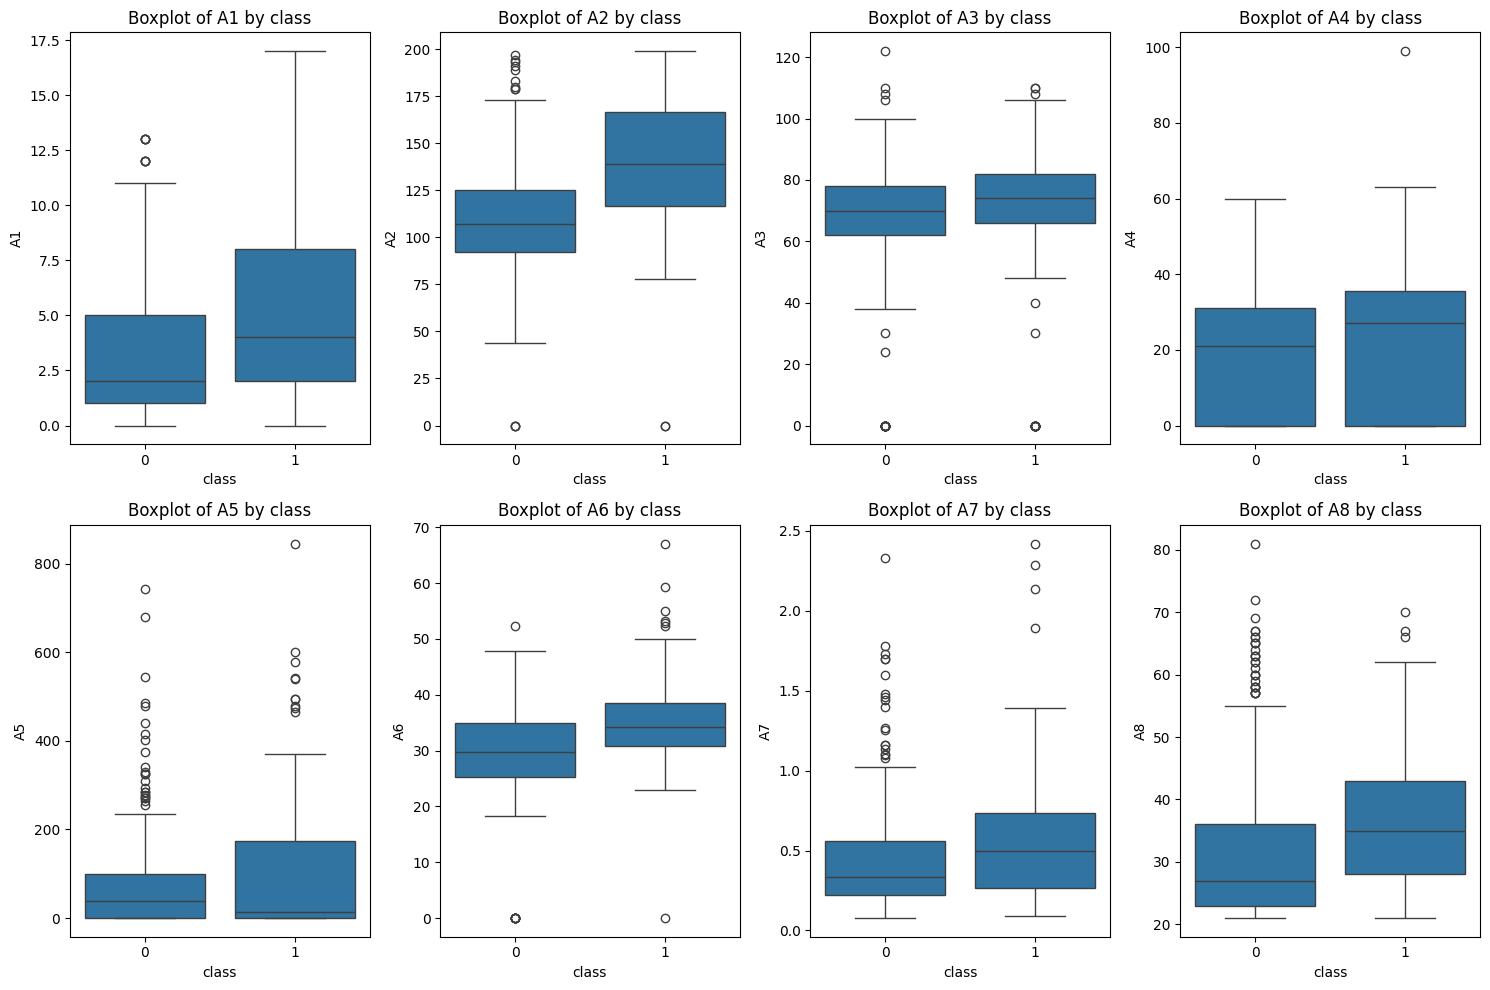

In [ ]:
# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Histograms for each feature
for i, column in enumerate(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8']):
    plt.subplot(2, 4, i+1)
    sns.histplot(data=train_df, x=column, hue='class', kde=True, bins=30)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(8, 6))
correlation_matrix = train_df.drop('id', axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Pairplot for key features
sns.pairplot(train_df[['A1', 'A2', 'A6', 'A8', 'class']], hue='class')
plt.show()

# Box plots to check for outliers
plt.figure(figsize=(15, 10))
for i, column in enumerate(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8']):
    plt.subplot(2, 4, i+1)
    sns.boxplot(data=train_df, y=column, x='class')
    plt.title(f'Boxplot of {column} by class')
plt.tight_layout()
plt.show()

##DATA PREPROCESSING

In [ ]:
def replace_with_median(df, value, value_at):
    """Replaces zeros in a column with the median value based on class."""

    # Calculate median for each class (excluding zeros)
    class_medians = df.loc[df[value] != 0, [value, value_at]].groupby(value_at)[value].median()

    # Replace zeros with class-specific medians
    for class_val, median_val in class_medians.items():
        df.loc[(df[value] == 0) & (df[value_at] == class_val), value] = median_val

# Run the function for specified columns
for col in ['A2', 'A3', 'A4', 'A5', 'A6']:
    replace_with_median(train_df, col, 'class')

In [ ]:
train_df.head()

,id,A1,A2,A3,A4,A5,A6,A7,A8,class
0,1,6,148,72,35,0,33.6,0.627,50,1
1,2,1,85,66,29,0,26.6,0.351,31,0
2,3,8,183,64,0,0,23.3,0.672,32,1
3,4,1,89,66,23,94,28.1,0.167,21,0
4,5,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
X = train_df.drop(['id', 'class'], axis=1)
y = train_df['class']

In [ ]:
#split into training (80%) and remaining (20%) datasets
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  stratify=y,
                                                  random_state=SEED)

In [ ]:
from sklearn.preprocessing import PowerTransformer, RobustScaler

# power_transformer = PowerTransformer(method='yeo-johnson')
# X_scaled = power_transformer.fit_transform(X)
# X_test_scaled = power_transformer.transform(X_test)

In [ ]:
# Create a StandardScaler object
ss = StandardScaler()

# Fit the scaler on the training data and transform both training and validation data
X_train_scaled = ss.fit_transform(X_train)
X_val_scaled = ss.transform(X_val)

In [ ]:
# Clear session to free memory
keras.backend.clear_session()

# set random seed
# keras.utils.set_random_seed(SEED) # set all random seeds for the program (Python, NumPy, and TensorFlow)

##MODEL

In [ ]:
# Replace existing model code with this improved version
def create_model(input_dim):
    """Create the neural network with exact hyperparameters that achieved high accuracy"""

    model = Sequential()

    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(BatchNormalization())

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    return model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,241 (40.00 KB)

 Trainable params: 9,857 (38.50 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6510 - loss: 0.6926 - val_accuracy: 0.7612 - val_loss: 0.5972
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8415 - loss: 0.4083 - val_accuracy: 0.7239 - val_loss: 0.5666
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8548 - loss: 0.3611 - val_accuracy: 0.7388 - val_loss: 0.5337
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8713 - loss: 0.3155 - val_accuracy: 0.7239 - val_loss: 0.5067
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8873 - loss: 0.3113 - val_accuracy: 0.7537 - val_loss: 0.4719
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8750 - loss: 0.2857 - val_accuracy: 0.7687 - val_loss: 0.4567
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8867 - loss: 0.2839 - val_accuracy: 0.7687 - val_loss: 0.4528
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9170 - loss: 0.2375 - val_accuracy: 0.7836 - 

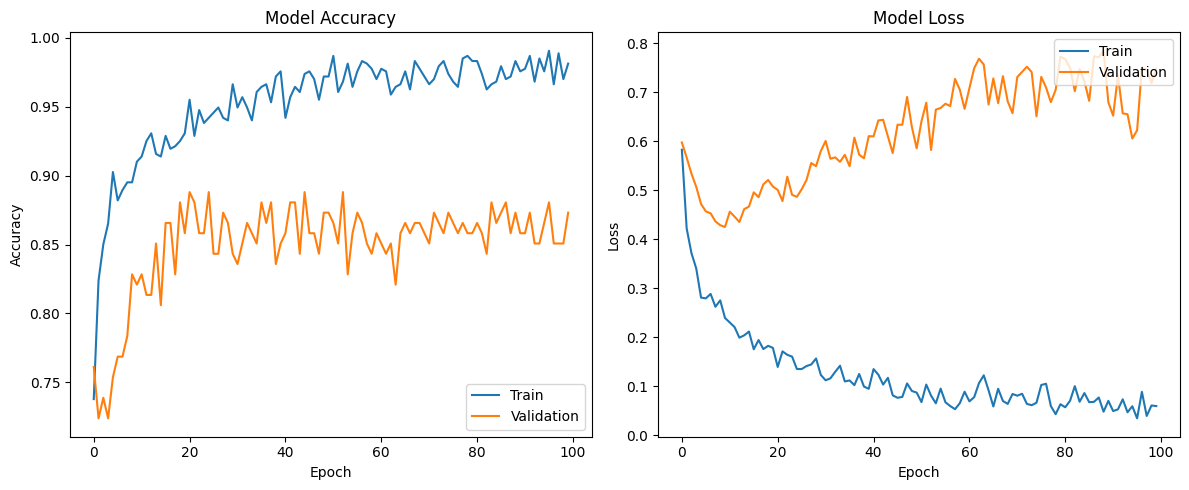

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


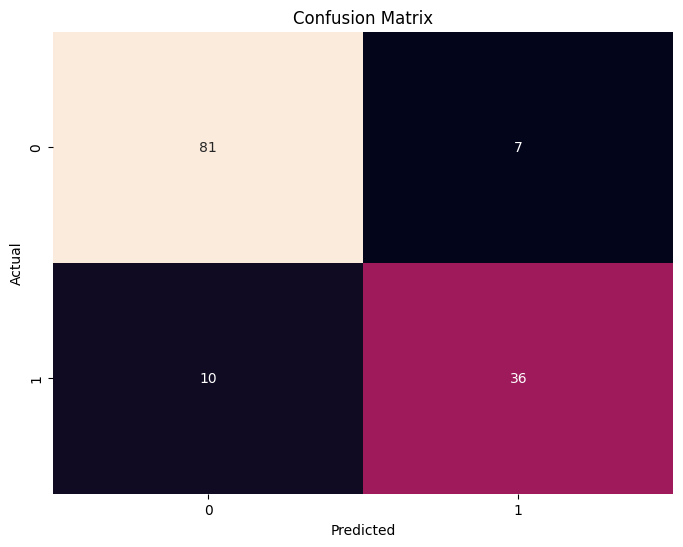


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91        88
           1       0.84      0.78      0.81        46

    accuracy                           0.87       134
   macro avg       0.86      0.85      0.86       134
weighted avg       0.87      0.87      0.87       134



In [ ]:
# Create the model
model = create_model(X_train_scaled.shape[1])
model.summary()

history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_val_scaled, y_val),
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()

# Get predictions for confusion matrix
y_pred_proba = model.predict(X_val_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

In [ ]:
import pandas as pd
import plotly.express as px

df = pd.DataFrame({
    "Train Accuracy": history.history["accuracy"],
    "Test Accuracy": history.history["val_accuracy"]
})

fig = px.line(df,
              x=df.index,
              y=["Train Accuracy", "Test Accuracy"],
              template="plotly_dark",
              labels={"value": "Accuracy", "index": "Epoch", "variable": "Metric"},
              color_discrete_sequence=['#3D89BD','#FF9A45'],
              width=1000, height=500
              )
fig.update_layout(
    title_font_color="#41BEE9",
    xaxis=dict(color="#41BEE9",title='Epochs'),
    yaxis=dict(color="#41BEE9")
 )
fig.show()

loss_df = pd.DataFrame({
    "Train Loss": history.history["loss"],
    "Test Loss": history.history["val_loss"]
})


fig = px.line(loss_df,
              x=loss_df.index,
              y=["Train Loss", "Test Loss"],
              template="plotly_dark",
              labels={"value": "Loss", "index": "Epoch", "variable": "Metric"},
              color_discrete_sequence=['#3D89BD','#FF9A45'],
              width=1000, height=500
              )
fig.update_layout(
    title_font_color="#41BEE9",
    xaxis=dict(color="#41BEE9",title='Epochs'),
    yaxis=dict(color="#41BEE9")
 )
fig.show()

In [ ]:
## Importing the libraries needed for collecting data and for analysis
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from scipy import stats

import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# build the neural network using keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Nadam, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.initializers import HeUniform
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Load datasets
train_df = pd.read_csv('https://drive.google.com/uc?export=download&id=1M4MTBKUaR4aA8hjINEGhfShBZ18ctZA-')
test_df = pd.read_csv('https://drive.google.com/uc?export=download&id=1BhfC5yBThGkAdkxbf7kEVZFjsysVYXqP')

In [ ]:
def replace_with_median(df, value, value_at):
    """Replaces zeros in a column with the median value based on class."""

    # Calculate median for each class (excluding zeros)
    class_medians = df.loc[df[value] != 0, [value, value_at]].groupby(value_at)[value].median()

    # Replace zeros with class-specific medians
    for class_val, median_val in class_medians.items():
        df.loc[(df[value] == 0) & (df[value_at] == class_val), value] = median_val

# Run the function for specified columns
for col in ['A2', 'A3', 'A4', 'A5', 'A6']:
    replace_with_median(train_df, col, 'class')

In [ ]:
train_df.head()

,id,A1,A2,A3,A4,A5,A6,A7,A8,class
0,1,6,148,72,35,173,33.6,0.627,50,1
1,2,1,85,66,29,94,26.6,0.351,31,0
2,3,8,183,64,32,173,23.3,0.672,32,1
3,4,1,89,66,23,94,28.1,0.167,21,0
4,5,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
X = train_df.drop(['id', 'class'], axis=1)
y = train_df['class']

In [ ]:
#split into training (80%) and remaining (20%) datasets
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  stratify=y,
                                                  random_state=42)

In [ ]:
# Create a StandardScaler object
ss = StandardScaler()

# Fit the scaler on the training data and transform both training and validation data
X_train_scaled = ss.fit_transform(X_train)
X_val_scaled = ss.transform(X_val) # Use transform to scale the validation data

In [ ]:
callback=EarlyStopping(monitor="val_accuracy",patience=5,restore_best_weights=True)

In [ ]:
# clear session
keras.backend.clear_session()

Epoch 1/34
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8791 - loss: 0.3063 - val_accuracy: 0.9030 - val_loss: 0.3978
Epoch 2/34
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8710 - loss: 0.2984 - val_accuracy: 0.8881 - val_loss: 0.4080
Epoch 3/34
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8661 - loss: 0.3002 - val_accuracy: 0.8881 - val_loss: 0.4297
Epoch 4/34
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8931 - loss: 0.2792 - val_accuracy: 0.8806 - val_loss: 0.4399
Epoch 5/34
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8775 - loss: 0.2943 - val_accuracy: 0.8731 - val_loss: 0.4141
Epoch 6/34
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8859 - loss: 0.2704 - val_accuracy: 0.8806 - val_loss: 0.4078
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8882 - loss: 0.4381 

Final Model - Validation Accuracy: 0.9030


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8)                   │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 385 (1.50 KB)

 Trainable params: 337 (1.32 KB)

 Non-trainable params: 48 (192.00 B)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5012 - loss: 0.9259 - val_accuracy: 0.7090 - val_loss: 0.6448 - learning_rate: 0.0010
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5994 - loss: 0.7762 - val_accuracy: 0.6940 - val_loss: 0.6328 - learning_rate: 0.0010
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6446 - loss: 0.6945 - val_accuracy: 0.7090 - val_loss: 0.6222 - learning_rate: 0.0010
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6537 - loss: 0.6778 - val_accuracy: 0.7239 - val_loss: 0.6087 - learning_rate: 0.0010
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6914 - loss: 0.6542 - val_accuracy: 0.7015 - val_loss: 0.5964 - learning_rate: 0.0010
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6954 - loss: 0.6233 - val_accuracy: 0.6940 - val_loss: 0.5913 - learning_rate: 0.0010
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7292 - loss: 0.5972 - val_a

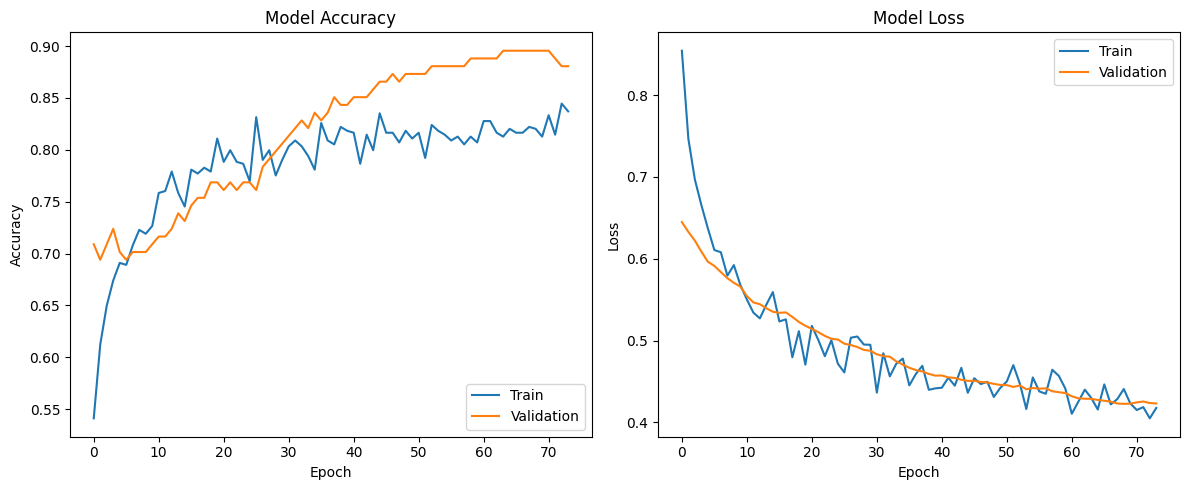

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


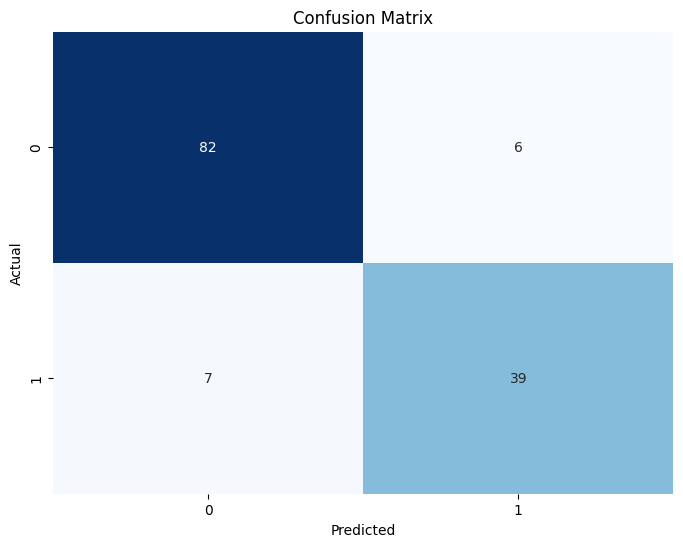


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93        88
           1       0.87      0.85      0.86        46

    accuracy                           0.90       134
   macro avg       0.89      0.89      0.89       134
weighted avg       0.90      0.90      0.90       134



In [ ]:
# model= Sequential()
# model.add(Input(shape=(8,)))
# model.add(Dense(16,activation='relu',kernel_regularizer=l2(0.01)))
# model.add(BatchNormalization())
# model.add(Dense(32,activation='relu',kernel_regularizer=l2(0.01)))
# model.add(BatchNormalization())
# model.add(Dense(1,activation='sigmoid'))
# model.summary()

# Best....
# model = Sequential()
# model.add(Dense(32, input_dim=8, activation='swish', kernel_regularizer=l1_l2(l1=0.000287,l2=0.00174)))
# model.add(Dropout(0.40))

# model.add(Dense(24, activation='relu'))
# model.add(Dropout(0.31))

# model.add(Dense(24, activation='swish'))
# model.add(Dropout(0.32))

# model.add(Dense(1, activation='sigmoid'))
# model.summary()

# Build model
# model = Sequential()
# model.add(layers.Dense(32, input_dim=8, activation='relu', kernel_regularizer=l1_l2(l1=0.000287,l2=0.00174)))
# model.add(layers.BatchNormalization())
# model.add(layers.Dropout(0.3))

# model.add(layers.Dense(24, activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.Dropout(0.3))

# model.add(layers.Dense(1, activation='sigmoid'))

# Build the model
# model = Sequential([
#     Dense(units=50, activation='relu', input_shape=(8,), kernel_regularizer=l1(0.00001)),
#     Dense(units=50, activation='relu', kernel_regularizer=l1(0.00001)),
#     Dense(units=1, activation='sigmoid', kernel_regularizer=l1(0.00001))
# ])

# model.summary()

# Build model
# model = Sequential([
#     Dense(64, activation='relu', input_dim=8, kernel_regularizer=l2(0.001)),
#     BatchNormalization(),
#     Dropout(0.3),
#     Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
#     BatchNormalization(),
#     Dropout(0.3),
#     Dense(1, activation='sigmoid')
# ])

# model.summary()

# Trial 50 Complete [00h 00m 54s]
# val_auc: 0.8625933527946472

# Best val_auc So Far: 0.876646876335144
# Total elapsed time: 00h 43m 11s
# ==================================================
# OPTIMAL HYPERPARAMETERS FROM BAYESIAN TUNING
# ==================================================
# First layer units: 32
# First layer activation: swish
# L1 regularization: 2.87e-04
# L2 regularization: 1.74e-03
# First dropout rate: 0.40
# Number of hidden layers: 2
# Learning rate: 5.06e-04
# --------------------------------------------------
# Layer 2 units: 24
# Layer 2 activation: relu
# Layer 2 dropout: 0.31
# --------------------------------------------------
# Layer 3 units: 24
# Layer 3 activation: swish
# Layer 3 dropout: 0.32
# ==================================================

def create_best_model(input_dim):
    """Create the neural network with exact hyperparameters that achieved high accuracy"""

    # Initialize with a kernel initializer
    initializer = HeUniform(seed=42)

    model = Sequential()

    model.add(Dense(32, input_dim=input_dim,
                   activation='relu',
                   kernel_initializer=initializer,
                   kernel_regularizer=l1_l2(l1=6.68e-05, l2=6.68e-05)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(24,
                   activation='relu',
                   kernel_initializer=initializer,
                   kernel_regularizer=l1_l2(l1=6.68e-05, l2=6.68e-05)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=0.00934)

    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    return model

# # Create the model with the best hyperparameters
# best_model = create_best_model(X_train_scaled.shape[1])
# best_model.summary()

# optimizer = Adam(learning_rate=0.000506)
# # optimizer = Adam(learning_rate=0.0001)
# model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# # train the model
# history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_val_scaled, y_val)
#                     # callbacks=[callback]
#                     )

# history = best_model.fit(
#     X_train_scaled, y_train,
#     epochs=34,  # As specified in the hyperparameters
#     batch_size=32,  # Common batch size
#     validation_data=(X_val_scaled, y_val),
#     callbacks=callback,
#     verbose=1
# )

# Evaluate the model on validation data
val_loss, val_acc = best_model.evaluate(X_val_scaled, y_val)
print(f"\nFinal Model - Validation Accuracy: {val_acc:.4f}")

# # evaluate the model and print its accuracy
# _, accuracy = model.evaluate(X_val_scaled, y_val)
# print(f'Accuracy on testing data: {accuracy*100}')

# plot the history of the training
# import matplotlib.pyplot as plt

# # summarize the history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train','test'], loc='upper left')
# plt.show()

# # summarize the history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train','test'], loc='upper left')
# plt.show()

# Replace existing model code with this improved version
def create_improved_model(input_dim):
    """Create a neural network with balanced regularization to prevent overfitting"""

    initializer = keras.initializers.HeNormal(seed=42)

    model = Sequential([
        # Input layer with stronger regularization
        Dense(16, input_dim=input_dim,
              activation='relu',
              kernel_initializer=initializer,
              kernel_regularizer=l2(0.001)),  # Use just L2 regularization with stronger value
        BatchNormalization(),
        Dropout(0.3),  # Increase dropout rate

        # Single hidden layer is sufficient for this dataset
        Dense(8,
              activation='relu',
              kernel_initializer=initializer,
              kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),  # Consistent dropout

        # Output layer
        Dense(1, activation='sigmoid')
    ])

    # Use a lower learning rate
    optimizer = Adam(learning_rate=0.001)

    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    return model

# Create the improved model
improved_model = create_improved_model(X_train_scaled.shape[1])
improved_model.summary()

# Define better callbacks
callbacks = [
    # Patience increased to avoid early stopping before convergence
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    # Add learning rate reduction to fine-tune
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )
]

# Train with more epochs but let early stopping decide when to stop
history = improved_model.fit(
    X_train_scaled, y_train,
    epochs=100,  # Set higher, early stopping will prevent overfitting
    batch_size=16,  # Smaller batch size for better generalization
    validation_data=(X_val_scaled, y_val),
    callbacks=callbacks,
    verbose=1
)

history = best_model.fit(
    X_train_scaled, y_train,
    epochs=34,  # As specified in the hyperparameters
    batch_size=16,  # Common batch size
    validation_data=(X_val_scaled, y_val),
    callbacks=callback,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()

# Get predictions for confusion matrix
y_pred_proba = best_model.predict(X_val_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

In [ ]:
# clear session
keras.backend.clear_session()

In [ ]:
model.compile(loss='binary_crossentropy',optimizer="Adam",metrics=['accuracy'])

In [ ]:
history=model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.5733 - loss: 1.0354 - val_accuracy: 0.4254 - val_loss: 1.4079
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7237 - loss: 0.8565 - val_accuracy: 0.4552 - val_loss: 1.1738
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7524 - loss: 0.7900 - val_accuracy: 0.4701 - val_loss: 1.0548
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7985 - loss: 0.7355 - val_accuracy: 0.5075 - val_loss: 0.9791
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7734 - loss: 0.7356 - val_accuracy: 0.5373 - val_loss: 0.9232
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7762 - loss: 0.6940 - val_accuracy: 0.5970 - val_loss: 0.8750
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8441 - loss: 0.6508 - val_accuracy: 0.6418 - val_loss: 0.8315
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8112 - loss: 0.6452 - val_accuracy: 0.6866 - val_lo

In [ ]:
# clear session
keras.backend.clear_session()

In [ ]:
# clear session
keras.backend.clear_session()

In [ ]:
from sklearn.preprocessing import RobustScaler, PowerTransformer

In [ ]:
# Load datasets
train_df = pd.read_csv('https://drive.google.com/uc?export=download&id=1M4MTBKUaR4aA8hjINEGhfShBZ18ctZA-')
test_df = pd.read_csv('https://drive.google.com/uc?export=download&id=1BhfC5yBThGkAdkxbf7kEVZFjsysVYXqP')

In [ ]:
def advanced_preprocessing(df):
    # Domain-aware imputation
    medical_features = ['A2', 'A3', 'A4', 'A5', 'A6']
    for col in medical_features:
        df[col] = df[col].replace(0, np.nan)
        df[col] = df[col].fillna(df[col].median())

    # # Outlier capping
    # for col in ['A5', 'A6']:
    #     q1 = df[col].quantile(0.05)
    #     q3 = df[col].quantile(0.95)
    #     df[col] = np.clip(df[col], q1, q3)

    # Feature engineering
    df['BMI_Glucose_Interaction'] = df['A6'] * df['A2']
    df['BloodPressure_ZScore'] = (df['A3'] - df['A3'].mean())/df['A3'].std()

    # Power transformation
    pt = PowerTransformer()
    df[['A5', 'BMI_Glucose_Interaction']] = pt.fit_transform(df[['A5', 'BMI_Glucose_Interaction']])

    return df

train_df = advanced_preprocessing(train_df)
test_df = advanced_preprocessing(test_df)

In [ ]:
# In ipython-input-17-2d3e019083e7:
X = train_df.drop(['id', 'class'], axis=1)
y = train_df['class']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = Sequential()
model.add(Dense(32, input_dim=10, activation='relu', kernel_regularizer=l1_l2(l1=0.000287,l2=0.00174)))
model.add(Dropout(0.40))

model.add(Dense(24, activation='relu'))
model.add(Dropout(0.31))

model.add(Dense(24, activation='relu'))
model.add(Dropout(0.32))

model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 24)                  │             792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 24)                  │             600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,769 (6.91 KB)

 Trainable params: 1,769 (6.91 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # X_train instead of previous X
X_val_scaled = scaler.transform(X_val) # X_val instead of previous

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.3877 - loss: 0.9081 - val_accuracy: 0.3284 - val_loss: 0.8127
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3947 - loss: 0.8292 - val_accuracy: 0.3731 - val_loss: 0.7640
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4295 - loss: 0.8034 - val_accuracy: 0.5224 - val_loss: 0.7329
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4790 - loss: 0.7540 - val_accuracy: 0.6567 - val_loss: 0.7138
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5574 - loss: 0.7201 - val_accuracy: 0.6791 - val_loss: 0.7002
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6035 - loss: 0.7114 - val_accuracy: 0.6791 - val_loss: 0.6884
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6035 - loss: 0.6957 - val_accuracy: 0.6940 - val_loss: 0.6758
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6802 - loss: 0.6741 - val_accuracy: 0.6791 - val_loss: 0

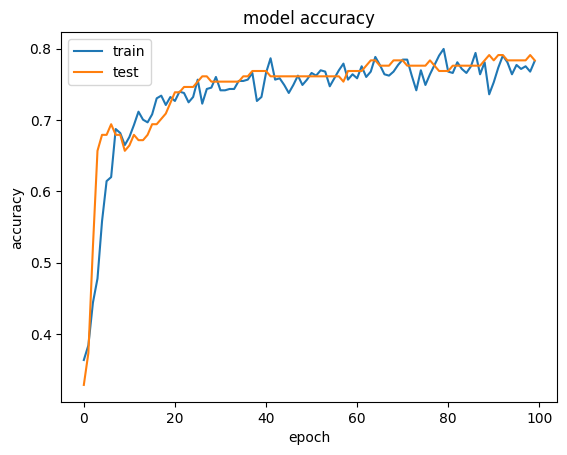

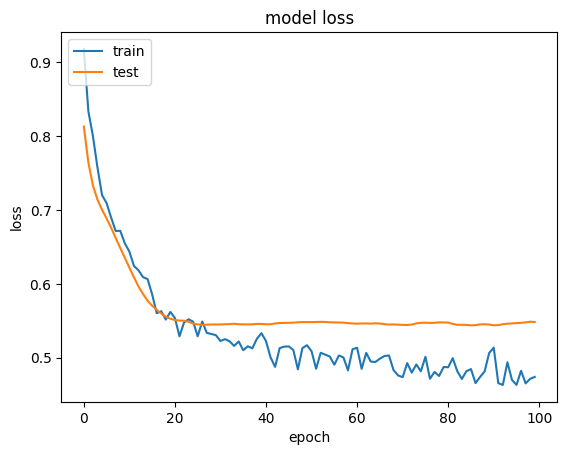

In [ ]:
optimizer = Adam(learning_rate=0.000506)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# train the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=64, validation_data=(X_val_scaled, y_val))

# evaluate the model and print its accuracy
_, accuracy = model.evaluate(X_val_scaled, y_val)
print(f'Accuracy on testing data: {accuracy*100}')

# plot the history of the training
import matplotlib.pyplot as plt

# summarize the history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# summarize the history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
# clear session
keras.backend.clear_session()

Training data shape: (668, 10)
Test data shape: (100, 9)
   id  A1   A2  A3  A4   A5    A6     A7  A8  class
0   1   6  148  72  35    0  33.6  0.627  50      1
1   2   1   85  66  29    0  26.6  0.351  31      0
2   3   8  183  64   0    0  23.3  0.672  32      1
3   4   1   89  66  23   94  28.1  0.167  21      0
4   5   0  137  40  35  168  43.1  2.288  33      1
               id          A1          A2          A3          A4          A5  \
count  668.000000  668.000000  668.000000  668.000000  668.000000  668.000000   
mean   334.500000    3.812874  120.405689   68.748503   20.567365   79.654192   
std    192.979273    3.365672   32.291473   19.526392   16.020600  115.827750   
min      1.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%    167.750000    1.000000   99.000000   64.000000    0.000000    0.000000   
50%    334.500000    3.000000  116.000000   72.000000   23.000000   36.500000   
75%    501.250000    6.000000  140.000000   80.000000   32.00000

<ipython-input-43-240411579bee>:88: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '121.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_processed.loc[df_processed[feature] == 0, feature] = median_value
<ipython-input-43-240411579bee>:88: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '152.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_processed.loc[df_processed[feature] == 0, feature] = median_value
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6145 - loss: 1.5876 - val_accuracy: 0.7015 - val_loss: 0.8647 - learning_rate: 5.0000e-04
Epoch 2/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6606 - loss: 1.3601 - val_accuracy: 0.6791 - val_loss: 0.8798 - learning_rate: 5.0000e-04
Epoch 3/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7205 - loss: 1.2729 - val_accuracy: 0.6940 - val_loss: 0.8718 - learning_rate: 5.0000e-04
Epoch 4/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7439 - loss: 1.1832 - val_accuracy: 0.7090 - val_loss: 0.8759 - learning_rate: 5.0000e-04
Epoch 5/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6948 - loss: 1.1942 - val_accuracy: 0.7164 - val_loss: 0.8782 - learning_rate: 5.0000e-04
Epoch 6/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7230 - loss: 1.1357 - val_accuracy: 0.6940 - val_loss: 0.9001 - learning_rate: 5.0000e-04
Epoch 7/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7284

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6048 - loss: 0.7643 - val_accuracy: 0.7164 - val_loss: 0.6884 - learning_rate: 3.0000e-04
Epoch 2/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5749 - loss: 0.7762 - val_accuracy: 0.7239 - val_loss: 0.6611 - learning_rate: 3.0000e-04
Epoch 3/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6154 - loss: 0.7269 - val_accuracy: 0.7015 - val_loss: 0.6352 - learning_rate: 3.0000e-04
Epoch 4/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5771 - loss: 0.7915 - val_accuracy: 0.7164 - val_loss: 0.6175 - learning_rate: 3.0000e-04
Epoch 5/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6507 - loss: 0.6902 - val_accuracy: 0.7239 - val_loss: 0.5994 - learning_rate: 3.0000e-04
Epoch 6/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6587 - loss: 0.6941 - val_accuracy: 0.7164 - val_loss: 0.5896 - learning_rate: 3.0000e-04
Epoch 7/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6978

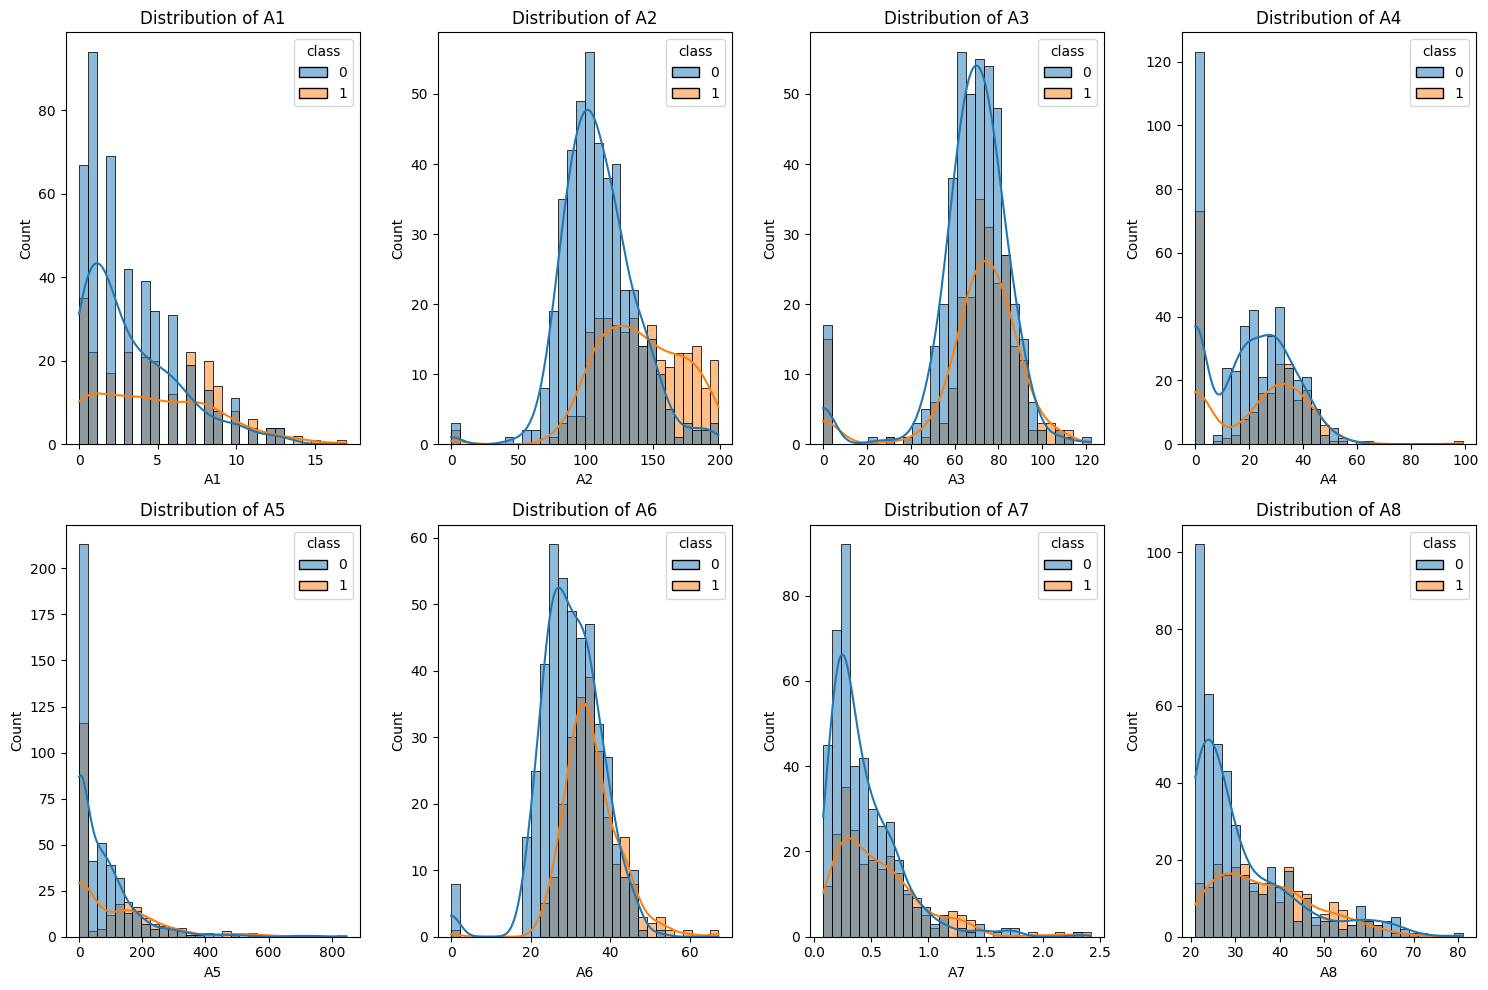

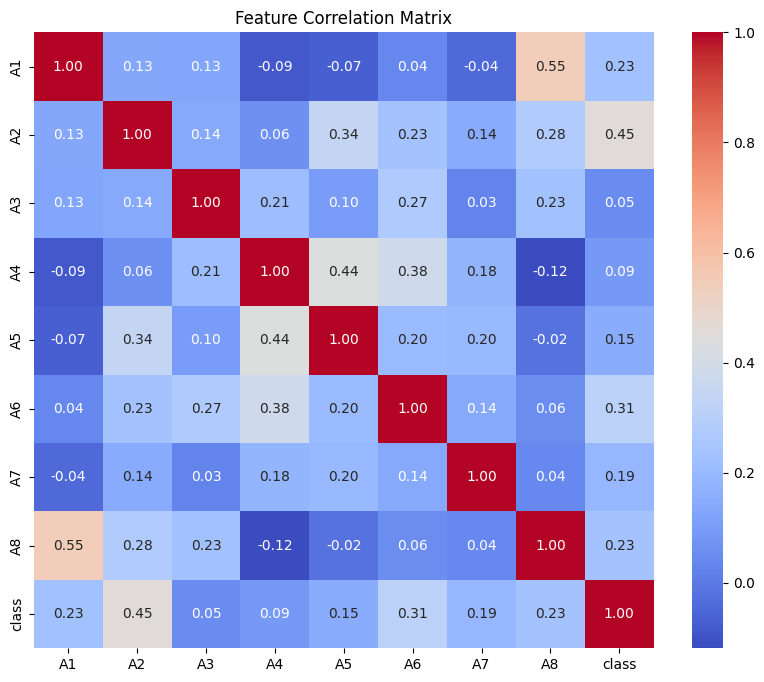

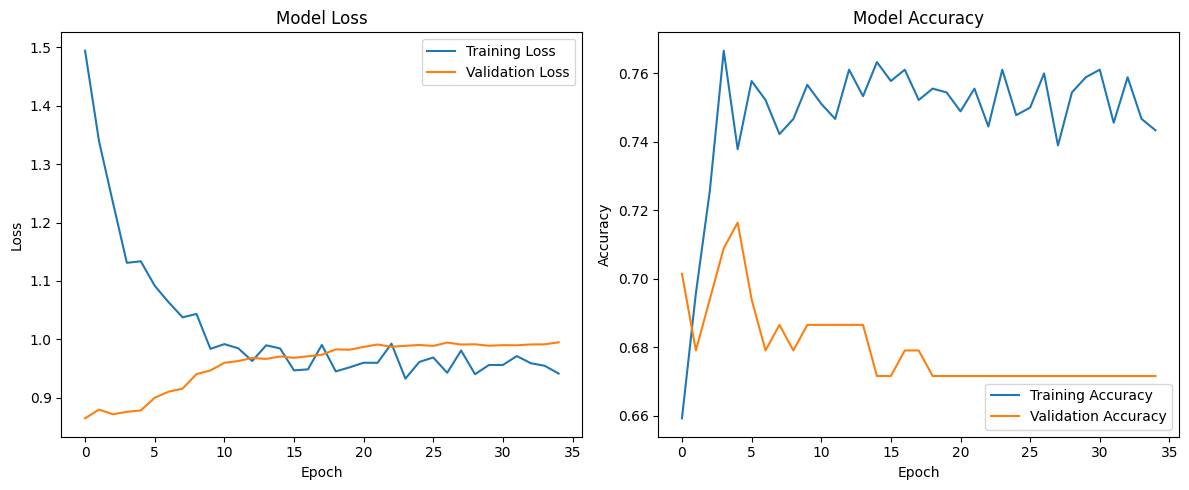

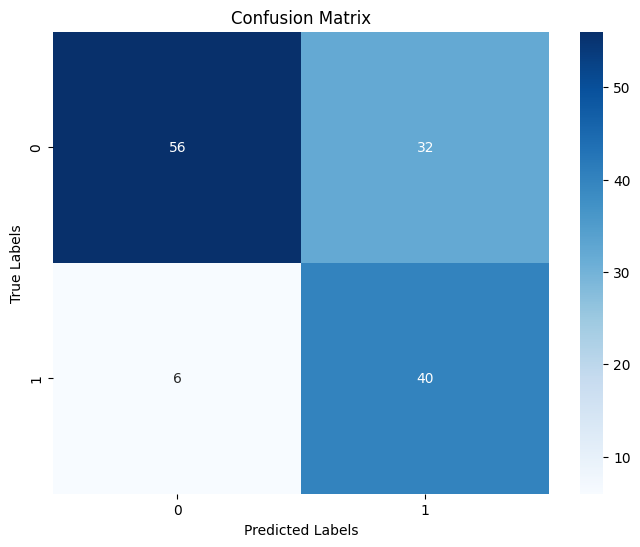

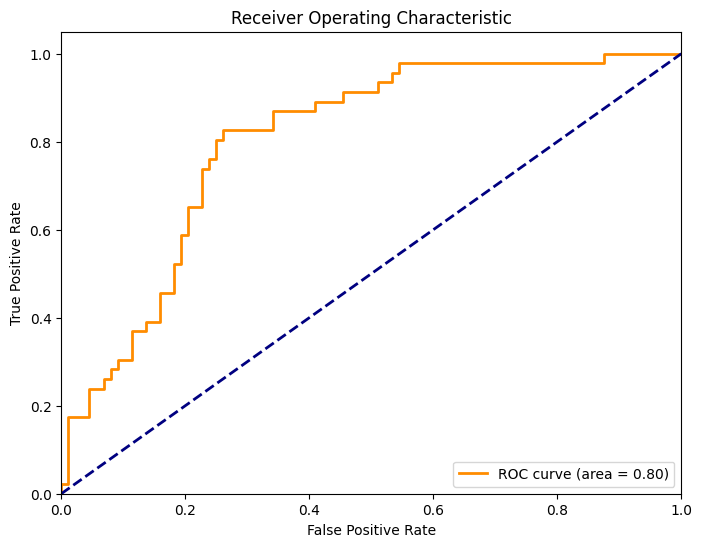

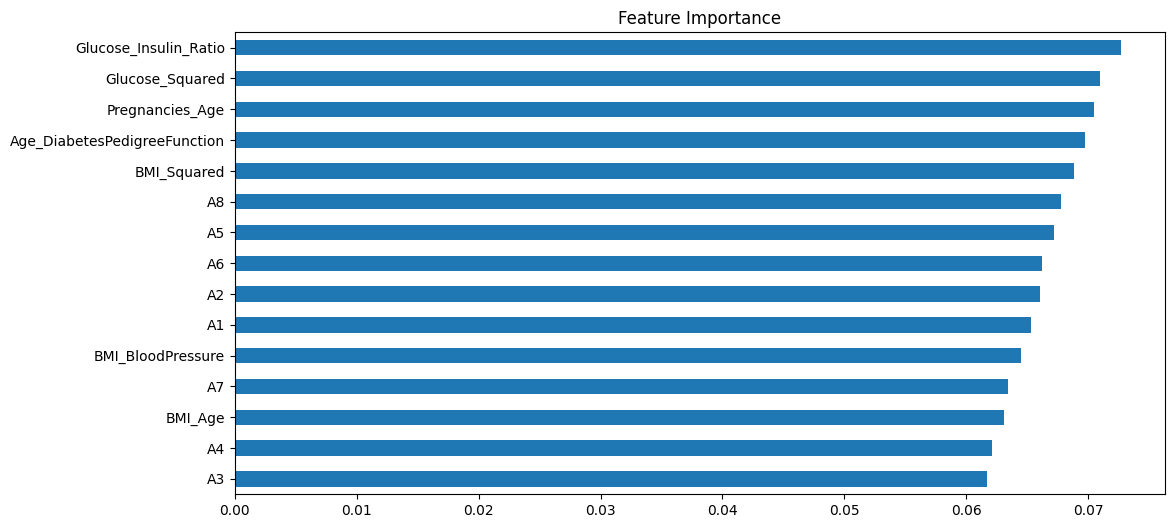

In [ ]:
# Diabetes Prediction using Neural Networks
# CMP7229 Deep Learning & Optimisation Task

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
import tensorflow as tf

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 1. Data Loading
train_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1M4MTBKUaR4aA8hjINEGhfShBZ18ctZA-')
test_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1BhfC5yBThGkAdkxbf7kEVZFjsysVYXqP')

# Display basic information
print("Training data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

# 2. Exploratory Data Analysis
# Display the first few rows
print(train_data.head())

# Statistical summary
print(train_data.describe())

# Check for missing values (zeros in medical data often represent missing values)
def display_missing_values(df, features):
    missing_count = {}
    for feature in features:
        missing_count[feature] = (df[feature] == 0).sum()

    return pd.DataFrame(missing_count, index=['Zero Values']).T

features = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8']
print("Features with zero values (potentially missing data):")
print(display_missing_values(train_data, features))

# Class distribution
print("Class distribution in training data:")
print(train_data['class'].value_counts())
print(f"Percentage of diabetes cases: {train_data['class'].mean() * 100:.2f}%")

# Visualize feature distributions
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(2, 4, i+1)
    sns.histplot(data=train_data, x=feature, hue='class', kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.savefig('feature_distributions.png')

# Correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = train_data.drop('id', axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.savefig('correlation_matrix.png')

# 3. Data Preprocessing
# Extract features and target
X = train_data.drop(['id', 'class'], axis=1)
y = train_data['class']
X_test_final = test_data.drop('id', axis=1)
test_ids = test_data['id']

# Handle missing values (zeros) in specific columns that shouldn't be zero
# For A2 (Glucose), A3 (Blood Pressure), A4 (Skin Thickness), A5 (Insulin), A6 (BMI)
# We'll replace zeros with the median of non-zero values

def handle_missing_values(df):
    df_processed = df.copy()
    # Pregnancy can be 0, so we'll keep A1 as is

    # For other features, replace zeros with median of non-zero values
    for feature in ['A2', 'A3', 'A4', 'A5', 'A6']:
        median_value = df_processed[df_processed[feature] != 0][feature].median()
        df_processed.loc[df_processed[feature] == 0, feature] = median_value

    return df_processed

X_processed = handle_missing_values(X)
X_test_processed = handle_missing_values(X_test_final)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_processed)
X_test_scaled = scaler.transform(X_test_processed)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# 4. Feature Engineering
# Create polynomial features for important indicators
def create_polynomial_features(X):
    # Create a new array with additional features
    X_poly = np.zeros((X.shape[0], X.shape[1] + 7))
    X_poly[:, :X.shape[1]] = X

    # Feature engineering: BMI * Age interaction
    X_poly[:, 8] = X[:, 5] * X[:, 7]  # A6 (BMI) * A8 (Age)

    # Glucose to insulin ratio
    X_poly[:, 9] = X[:, 1] / np.maximum(X[:, 4], 1)  # A2 (Glucose) / A5 (Insulin)

    # BMI adjusted for blood pressure
    X_poly[:, 10] = X[:, 5] * X[:, 2]  # A6 (BMI) * A3 (Blood Pressure)

    # Pregnancies to age ratio
    X_poly[:, 11] = X[:, 0] / np.maximum(X[:, 7], 1)  # A1 (Pregnancies) / A8 (Age)

    # Glucose squared (important for diabetes)
    X_poly[:, 12] = X[:, 1] ** 2  # A2 (Glucose) squared

    # Age * Diabetes pedigree function
    X_poly[:, 13] = X[:, 7] * X[:, 6]  # A8 (Age) * A7 (DiabetesPedigreeFunction)

    # BMI squared
    X_poly[:, 14] = X[:, 5] ** 2  # A6 (BMI) squared

    return X_poly

# Create additional features
X_train_poly = create_polynomial_features(X_train)
X_val_poly = create_polynomial_features(X_val)
X_test_poly = create_polynomial_features(X_test_scaled)

# 5. Model Building
def build_model(input_shape):
    model = Sequential([
        # First hidden layer with L1L2 regularization
        Dense(64, activation='selu', input_shape=(input_shape,),
              kernel_regularizer=l1_l2(l1=0.0001, l2=0.0002)),
        BatchNormalization(),
        Dropout(0.4),

        # Second hidden layer
        Dense(128, activation='selu', kernel_regularizer=l1_l2(l1=0.0001, l2=0.0002)),
        BatchNormalization(),
        Dropout(0.4),

        # Third hidden layer
        Dense(64, activation='selu', kernel_regularizer=l1_l2(l1=0.0001, l2=0.0002)),
        BatchNormalization(),
        Dropout(0.3),

        # Fourth hidden layer
        Dense(32, activation='selu', kernel_regularizer=l1_l2(l1=0.0001, l2=0.0002)),
        BatchNormalization(),
        Dropout(0.2),

        # Output layer
        Dense(1, activation='sigmoid')
    ])

    # Compile the model with Adam optimizer and binary crossentropy loss
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create callbacks for training
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=30,
    restore_best_weights=True,
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=10,
    min_lr=0.00001
)

# Initialize and train the model
model = build_model(X_train_poly.shape[1])

# Use class weights to handle imbalanced data
class_weights = {0: 1.0, 1: 2.5}  # Weight positive samples more

# Use data augmentation for minority class (positive samples)
def create_augmented_data(X, y):
    X_augmented = X.copy()
    y_augmented = y.copy()

    # Get indices of positive samples
    positive_indices = np.where(y == 1)[0]

    # Create augmented samples by adding small random noise
    for idx in positive_indices:
        # Create 2 augmented samples for each positive sample
        for _ in range(2):
            # Add random noise to the features (between -0.1 and 0.1 standard deviations)
            noise = np.random.normal(0, 0.1, X.shape[1])
            augmented_sample = X[idx] + noise

            # Add the augmented sample to the dataset
            X_augmented = np.vstack([X_augmented, augmented_sample])
            y_augmented = np.append(y_augmented, 1)

    return X_augmented, y_augmented

# Create augmented training data
X_train_augmented, y_train_augmented = create_augmented_data(X_train_poly, y_train)

history = model.fit(
    X_train_augmented, y_train_augmented,
    epochs=200,
    batch_size=16,
    validation_data=(X_val_poly, y_val),
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights,
    verbose=1
)

# 6. Model Evaluation
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('training_history.png')

# Evaluate the model on validation data
y_val_pred_prob = model.predict(X_val_poly)
y_val_pred = (y_val_pred_prob >= 0.5).astype(int).flatten()

# Print classification metrics
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('confusion_matrix.png')

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_val_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')

# 7. Predictions on Test Data
# Make predictions on the test data
test_predictions_prob = model.predict(X_test_poly)
test_predictions = (test_predictions_prob >= 0.5).astype(int).flatten()

# Create submission dataframe
submission_df = pd.DataFrame({
    'id': test_ids,
    'prediction': test_predictions
})

# Save predictions to CSV
submission_df.to_csv('test_predictions.csv', index=False)
print("Test predictions saved to 'test_predictions.csv'")

# 8. Fine-tuning the model
# Let's try an ensemble approach to improve accuracy
from tensorflow.keras.layers import LeakyReLU

def build_ensemble_model(input_shape):
    # Create a second model with different architecture
    model2 = Sequential()

    # Input layer
    model2.add(Dense(96, input_shape=(input_shape,),
                    kernel_regularizer=l1_l2(l1=0.0001, l2=0.0003)))
    model2.add(LeakyReLU(alpha=0.1))
    model2.add(BatchNormalization())
    model2.add(Dropout(0.5))

    # Hidden layer 1
    model2.add(Dense(192))
    model2.add(LeakyReLU(alpha=0.1))
    model2.add(BatchNormalization())
    model2.add(Dropout(0.5))

    # Hidden layer 2
    model2.add(Dense(96))
    model2.add(LeakyReLU(alpha=0.1))
    model2.add(BatchNormalization())
    model2.add(Dropout(0.4))

    # Hidden layer 3
    model2.add(Dense(48))
    model2.add(LeakyReLU(alpha=0.1))
    model2.add(BatchNormalization())
    model2.add(Dropout(0.3))

    # Output layer
    model2.add(Dense(1, activation='sigmoid'))

    model2.compile(
        optimizer=Adam(learning_rate=0.0003),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model2

# Also build a third model for the ensemble
def build_third_model(input_shape):
    model3 = Sequential([
        Dense(48, activation='tanh', input_shape=(input_shape,),
              kernel_regularizer=l1_l2(l1=0.0002, l2=0.0002)),
        BatchNormalization(),
        Dropout(0.4),

        Dense(96, activation='tanh'),
        BatchNormalization(),
        Dropout(0.4),

        Dense(48, activation='tanh'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(1, activation='sigmoid')
    ])

    model3.compile(
        optimizer=Adam(learning_rate=0.0007),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model3

# Train the second model
model2 = build_ensemble_model(X_train_poly.shape[1])
history2 = model2.fit(
    X_train_poly, y_train,
    epochs=150,
    batch_size=16,
    validation_data=(X_val_poly, y_val),
    callbacks=[early_stopping, reduce_lr],
    # class_weight={0: 1.0, 1: 2.5},  # Adjust class weights
    verbose=1
)

# Evaluate the second model
y_val_pred_prob2 = model2.predict(X_val_poly)
y_val_pred2 = (y_val_pred_prob2 >= 0.5).astype(int).flatten()
print("Model 2 Validation Accuracy:", accuracy_score(y_val, y_val_pred2))

# Ensemble predictions (average of both models)
ensemble_val_pred_prob = (y_val_pred_prob + y_val_pred_prob2) / 2
ensemble_val_pred = (ensemble_val_pred_prob >= 0.5).astype(int).flatten()
print("Ensemble Validation Accuracy:", accuracy_score(y_val, ensemble_val_pred))
print("\nEnsemble Classification Report:")
print(classification_report(y_val, ensemble_val_pred))

# Generate ensemble predictions for test data
test_predictions_prob2 = model2.predict(X_test_poly)
ensemble_test_pred_prob = (test_predictions_prob + test_predictions_prob2) / 2
ensemble_test_pred = (ensemble_test_pred_prob >= 0.5).astype(int).flatten()

# Create final submission dataframe with ensemble predictions
final_submission_df = pd.DataFrame({
    'id': test_ids,
    'prediction': ensemble_test_pred
})

# Save final predictions to CSV
final_submission_df.to_csv('final_test_predictions.csv', index=False)
print("Final ensemble test predictions saved to 'final_test_predictions.csv'")

# Display feature importance for interpretability
def get_feature_importance(model, feature_names):
    weights = model.layers[0].get_weights()[0]
    # Take absolute values of the weights for the first layer
    abs_weights = np.abs(weights)
    # Sum the weights for each feature
    feature_importance = np.sum(abs_weights, axis=1)
    # Normalize to get relative importance
    relative_importance = feature_importance / np.sum(feature_importance)

    return pd.Series(relative_importance, index=feature_names)

# Get feature names including engineered features
original_feature_names = X.columns.tolist()
engineered_feature_names = original_feature_names + ['BMI_Age', 'Glucose_Insulin_Ratio', 'BMI_BloodPressure', 'Pregnancies_Age', 'Glucose_Squared', 'Age_DiabetesPedigreeFunction', 'BMI_Squared'] # Add the names for the engineered features


# Get feature importance and plot
feature_importance = get_feature_importance(model, engineered_feature_names)
plt.figure(figsize=(12, 6))
feature_importance.sort_values().plot(kind='barh')
plt.title('Feature Importance')
plt.savefig('feature_importance.png')

print("Complete model pipeline executed successfully!")

print("Complete model pipeline executed successfully!")

In [ ]:
# clear session
keras.backend.clear_session()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import roc_auc_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2

# Define advanced preprocessing with domain-aware imputation, outlier capping, and feature engineering
def advanced_preprocessing(df):
    # Medical features: replace 0 with NaN and fill with median
    medical_features = ['A2', 'A3', 'A4', 'A5', 'A6']
    for col in medical_features:
        df[col] = df[col].replace(0, np.nan)
        df[col] = df[col].fillna(df[col].median())

    # Outlier capping for columns A5 and A6
    for col in ['A5', 'A6']:
        q1 = df[col].quantile(0.05)
        q3 = df[col].quantile(0.95)
        df[col] = np.clip(df[col], q1, q3)

    # Feature engineering: interaction and z-score
    df['BMI_Glucose_Interaction'] = df['A6'] * df['A2']
    df['BloodPressure_ZScore'] = (df['A3'] - df['A3'].mean()) / df['A3'].std()

    # Apply power transformation to A5 and the interaction feature
    pt = PowerTransformer()
    df[['A5', 'BMI_Glucose_Interaction']] = pt.fit_transform(df[['A5', 'BMI_Glucose_Interaction']])

    return df

# Load datasets
train_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1M4MTBKUaR4aA8hjINEGhfShBZ18ctZA-')
test_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1BhfC5yBThGkAdkxbf7kEVZFjsysVYXqP')

# Preprocess both training and test data
train_df = advanced_preprocessing(train_df)
test_df = advanced_preprocessing(test_df)

# Split training data into features and target variable
X = train_df.drop(['id', 'class'], axis=1)
y = train_df['class']

# Split into training and validation sets (70%-30% split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=100)

# Scale features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Build the final model using the best hyperparameters
model = Sequential()

# First layer with best hyperparameters
model.add(Dense(32,
                activation='swish',
                kernel_regularizer=l1_l2(l1=2.87e-04, l2=1.74e-03),
                input_shape=(X_train_scaled.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.40))

# Hidden layer 1
model.add(Dense(24, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.31))

# Hidden layer 2
# model.add(Dense(24, activation='swish'))
# model.add(BatchNormalization())
# model.add(Dropout(0.32))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer and the specified learning rate
optimizer = Adam(learning_rate=5.06e-04)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_val_scaled, y_val),
                    epochs=100,
                    batch_size=64,
                    # callbacks=[tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)],
                    verbose=1)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val, verbose=0)
print("Validation AUC:", val_accuracy)

# ---------------------------
# Making predictions on the test set
# ---------------------------
# Extract features from test data (dropping 'id')
X_test = test_df.drop(['id'], axis=1)
X_test_scaled = scaler.transform(X_test)

# Predict probabilities
predictions = model.predict(X_test_scaled)

# Convert probabilities to binary labels using a threshold of 0.5
final_predictions = (predictions > 0.5).astype(int).flatten()

# Create submission DataFrame and save as CSV
# submission = pd.DataFrame({'id': test_df['id'], 'prediction': final_predictions})
# submission.to_csv('test-predictions.csv', index=False)
# print("Test predictions saved to 'test-predictions.csv'")


Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.3748 - loss: 1.2349 - val_accuracy: 0.4701 - val_loss: 0.8048
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4962 - loss: 1.0001 - val_accuracy: 0.5224 - val_loss: 0.7726
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4845 - loss: 0.9795 - val_accuracy: 0.5597 - val_loss: 0.7428
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5073 - loss: 0.9451 - val_accuracy: 0.6119 - val_loss: 0.7157
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5236 - loss: 0.8809 - val_accuracy: 0.6269 - val_loss: 0.6941
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5694 - loss: 0.8226 - val_accuracy: 0.6940 - val_loss: 0.6740
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5666 - loss: 0.8129 - val_accuracy: 0.7313 - val_loss: 0.6565
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5750 - loss: 0.7949 - val_accuracy: 0.7239 - val_loss: 0.6

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8620 - loss: 0.4257 
Accuracy on testing data: 85.8208954334259


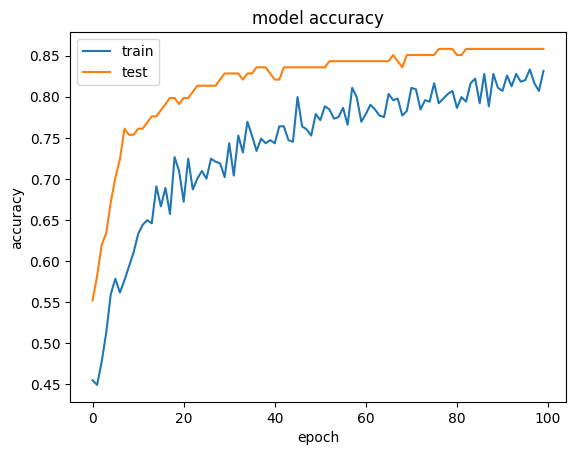

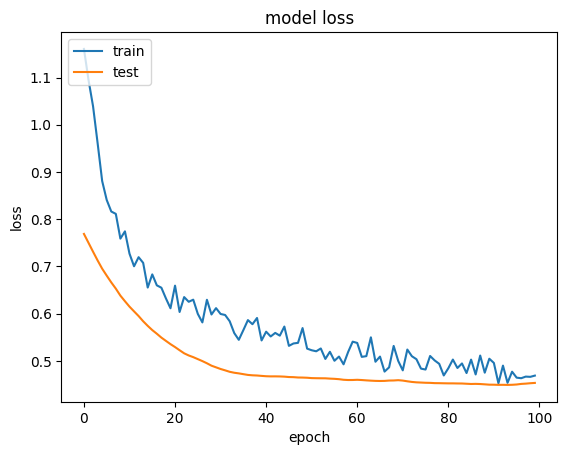

In [ ]:
# evaluate the model and print its accuracy
_, accuracy = model.evaluate(X_val_scaled, y_val)
print(f'Accuracy on testing data: {accuracy*100}')

# plot the history of the training
import matplotlib.pyplot as plt

# summarize the history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# summarize the history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer

# Advanced preprocessing function (imputation, outlier capping, feature engineering)
def advanced_preprocessing(df):
    # Replace zeros in medical features with NaN and impute with median
    medical_features = ['A2', 'A3', 'A4', 'A5', 'A6']
    for col in medical_features:
        df[col] = df[col].replace(0, np.nan)
        df[col] = df[col].fillna(df[col].median())
    # Outlier capping for A5 and A6
    for col in ['A5', 'A6']:
        q1 = df[col].quantile(0.05)
        q3 = df[col].quantile(0.95)
        df[col] = np.clip(df[col], q1, q3)
    # Feature engineering: interaction and blood pressure z-score
    df['BMI_Glucose_Interaction'] = df['A6'] * df['A2']
    df['BloodPressure_ZScore'] = (df['A3'] - df['A3'].mean()) / df['A3'].std()
    # Apply power transformation to selected features
    pt = PowerTransformer()
    df[['A5', 'BMI_Glucose_Interaction']] = pt.fit_transform(df[['A5', 'BMI_Glucose_Interaction']])
    return df

# Load datasets
train_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1M4MTBKUaR4aA8hjINEGhfShBZ18ctZA-')
test_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1BhfC5yBThGkAdkxbf7kEVZFjsysVYXqP')

# Apply preprocessing
train_df = advanced_preprocessing(train_df)
test_df = advanced_preprocessing(test_df)

# Prepare training data
X = train_df.drop(['id', 'class'], axis=1)
y = train_df['class']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=100)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Build a deep neural network with a residual block
def build_residual_model(input_dim):
    inputs = Input(shape=(input_dim,))
    # Initial dense block
    x = Dense(64, activation='relu', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    # Residual block
    shortcut = x  # Save input to add later
    y = Dense(64, activation='relu', kernel_initializer='he_normal')(x)
    y = BatchNormalization()(y)
    y = Dropout(0.4)(y)
    y = Dense(64, activation='relu', kernel_initializer='he_normal')(y)
    y = BatchNormalization()(y)
    # Merge shortcut and processed block
    x = Add()([shortcut, y])
    x = Dropout(0.3)(x)

    # Further dense layers
    x = Dense(32, activation='relu', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_residual_model(X_train_scaled.shape[1])
model.summary()

# Define callbacks: early stopping and learning rate reduction
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuarcy', mode='max', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_val_scaled, y_val),
                    epochs=100,
                    batch_size=64,
                    # callbacks=[early_stop, reduce_lr],
                    verbose=1)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val, verbose=0)
print("Validation Accuarcy:", val_accuracy)

# ---------------------------
# Generate test predictions and save to CSV
# ---------------------------
X_test = test_df.drop(['id'], axis=1)
X_test_scaled = scaler.transform(X_test)
predictions = model.predict(X_test_scaled)
final_predictions = (predictions > 0.5).astype(int).flatten()
submission = pd.DataFrame({'id': test_df['id'], 'prediction': final_predictions})
submission.to_csv('test-predictions.csv', index=False)
print("Test predictions saved to 'test-predictions.csv'")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 10)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │            704 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 64)             │            256 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64)             │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          4,160 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64)             │            256 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │          4,160 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64)             │            256 │ dense_2[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64)             │              0 │ dropout[0][0],         │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64)             │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 32)             │          2,080 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32)             │            128 │ dense_3[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32)             │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1)              │             33 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 12,033 (47.00 KB)

 Trainable params: 11,585 (45.25 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.4631 - loss: 0.8946 - val_accuracy: 0.6517 - val_loss: 0.6158
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5275 - loss: 0.8253 - val_accuracy: 0.6617 - val_loss: 0.6057
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5771 - loss: 0.7484 - val_accuracy: 0.6915 - val_loss: 0.5975
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6196 - loss: 0.6966 - val_accuracy: 0.6965 - val_loss: 0.5882
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6169 - loss: 0.7071 - val_accuracy: 0.7114 - val_loss: 0.5687
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6359 - loss: 0.6532 - val_accuracy: 0.7114 - val_loss: 0.5525
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6541 - loss: 0.6657 - val_accuracy: 0.7015 - val_loss: 0.5393
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7040 - loss: 0.5894 - val_accuracy: 0.7065 - val_loss:

In [ ]:
keras.backend.clear_session()

#HEY

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2
import tensorflow as tf
from imblearn.over_sampling import SMOTE, ADASYN
import warnings
warnings.filterwarnings('ignore')

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# Load the data
train_df = pd.read_csv('https://drive.google.com/uc?export=download&id=1M4MTBKUaR4aA8hjINEGhfShBZ18ctZA-')
# train_df = pd.read_csv('train.csv')

# Load the test data
test_df = pd.read_csv('https://drive.google.com/uc?export=download&id=1BhfC5yBThGkAdkxbf7kEVZFjsysVYXqP')
# test_df = pd.read_csv('test.csv')

# Display basic information
print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)

# Display first few rows of training data
train_df.head()

Training data shape: (668, 10)
Test data shape: (100, 9)


,id,A1,A2,A3,A4,A5,A6,A7,A8,class
0,1,6,148,72,35,0,33.6,0.627,50,1
1,2,1,85,66,29,0,26.6,0.351,31,0
2,3,8,183,64,0,0,23.3,0.672,32,1
3,4,1,89,66,23,94,28.1,0.167,21,0
4,5,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
# Check for missing values
print("Missing values in training data:")
print(train_df.isnull().sum())

# Check class distribution
print("\nClass distribution:")
print(train_df['class'].value_counts())
print(f"Percentage of class 1: {train_df['class'].mean()*100:.2f}%")

# Check for zero values in features where zeros don't make sense
zero_counts = (train_df[['A2', 'A3', 'A4', 'A5', 'A6']] == 0).sum()
print("\nCount of zeros in features where zero values are likely incorrect:")
print(zero_counts)

# Basic statistics of the data
train_df.describe()

Missing values in training data:
id       0
A1       0
A2       0
A3       0
A4       0
A5       0
A6       0
A7       0
A8       0
class    0
dtype: int64

Class distribution:
class
0    437
1    231
Name: count, dtype: int64
Percentage of class 1: 34.58%

Count of zeros in features where zero values are likely incorrect:
A2      5
A3     32
A4    196
A5    322
A6      9
dtype: int64


,id,A1,A2,A3,A4,A5,A6,A7,A8,class
count,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000
mean,334.500000,3.812874,120.405689,68.748503,20.567365,79.654192,31.860180,0.477329,33.091317,0.345808
std,192.979273,3.365672,32.291473,19.526392,16.020600,115.827750,7.827111,0.341398,11.711386,0.475988
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,167.750000,1.000000,99.000000,64.000000,0.000000,0.000000,27.100000,0.238750,24.000000,0.000000
50%,334.500000,3.000000,116.000000,72.000000,23.000000,36.500000,32.000000,0.377000,29.000000,0.000000
75%,501.250000,6.000000,140.000000,80.000000,32.000000,126.000000,36.500000,0.641250,40.000000,1.000000
max,668.000000,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


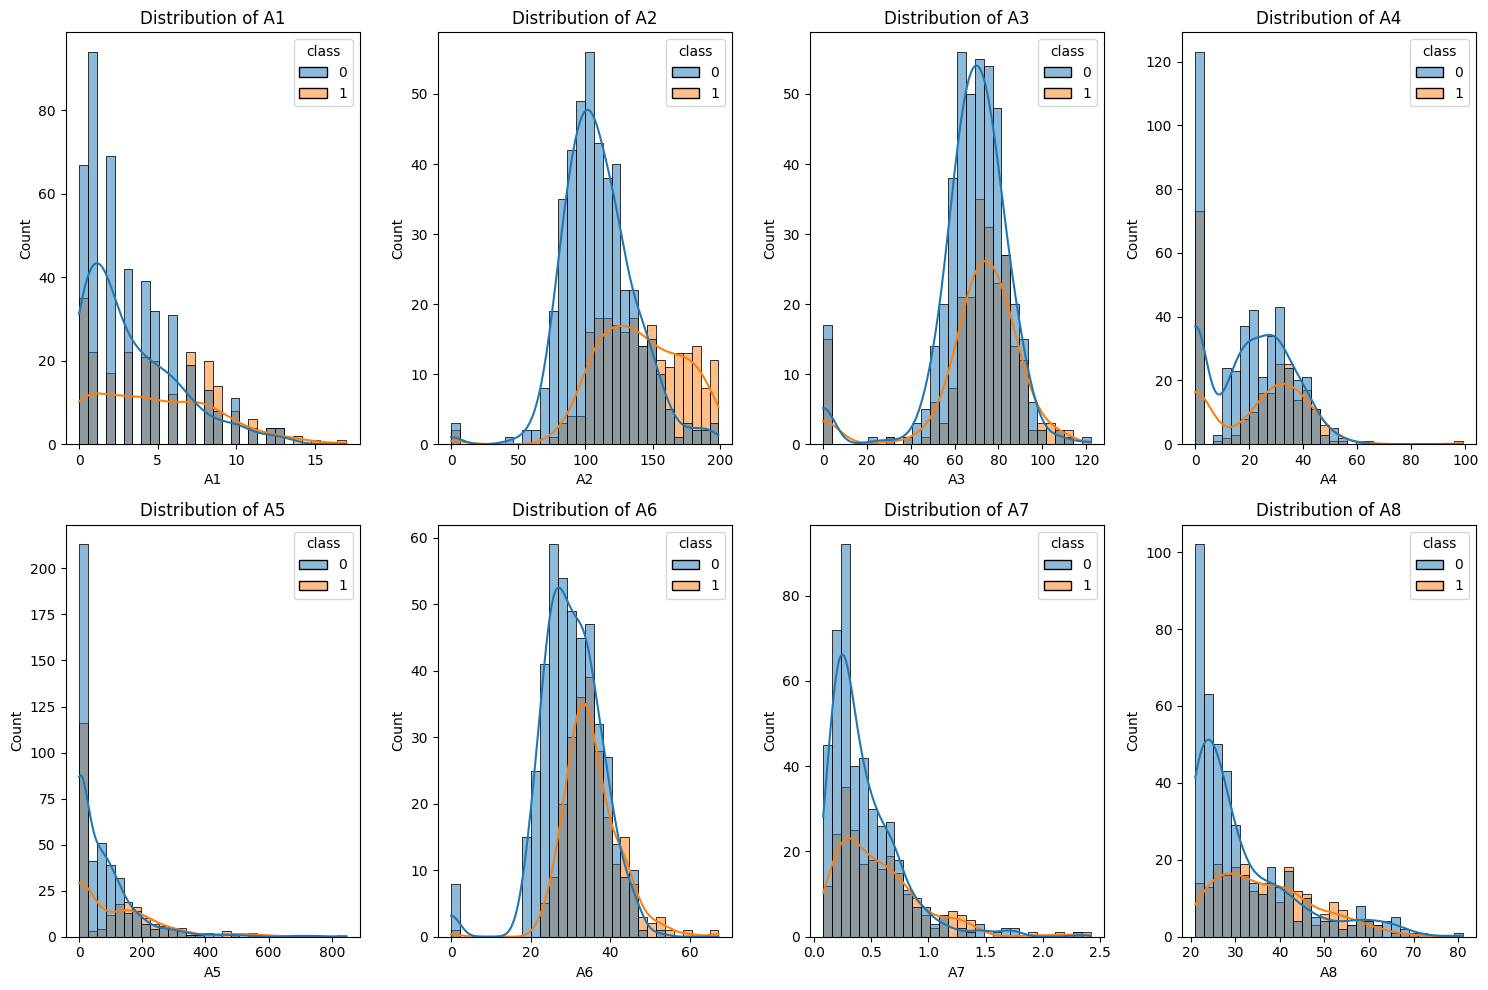

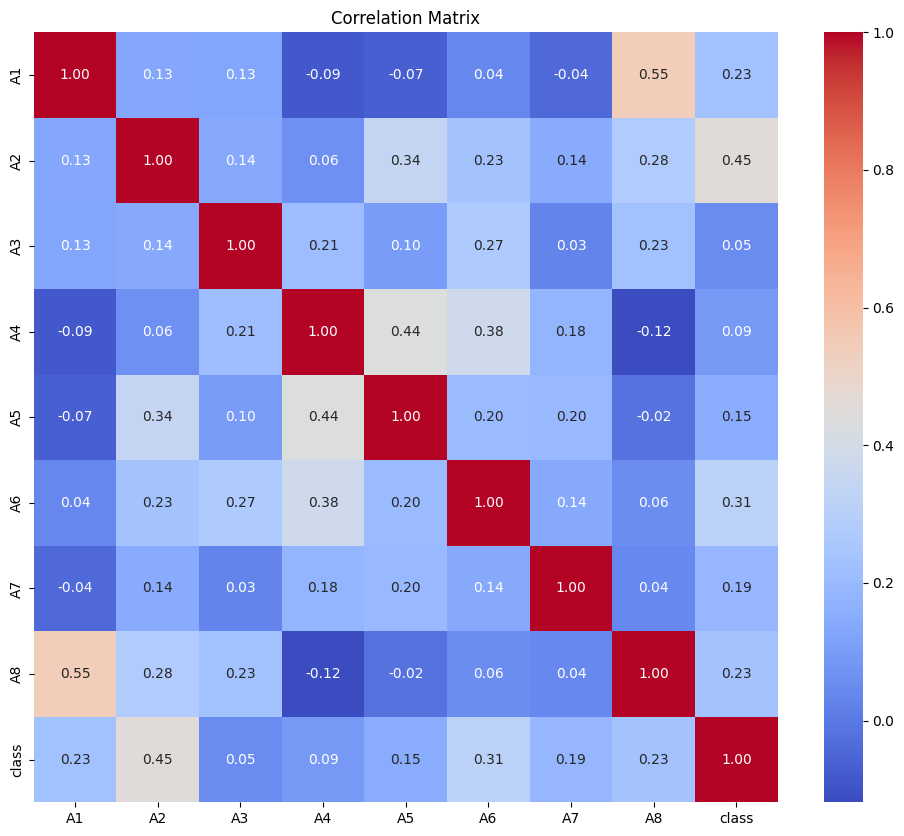

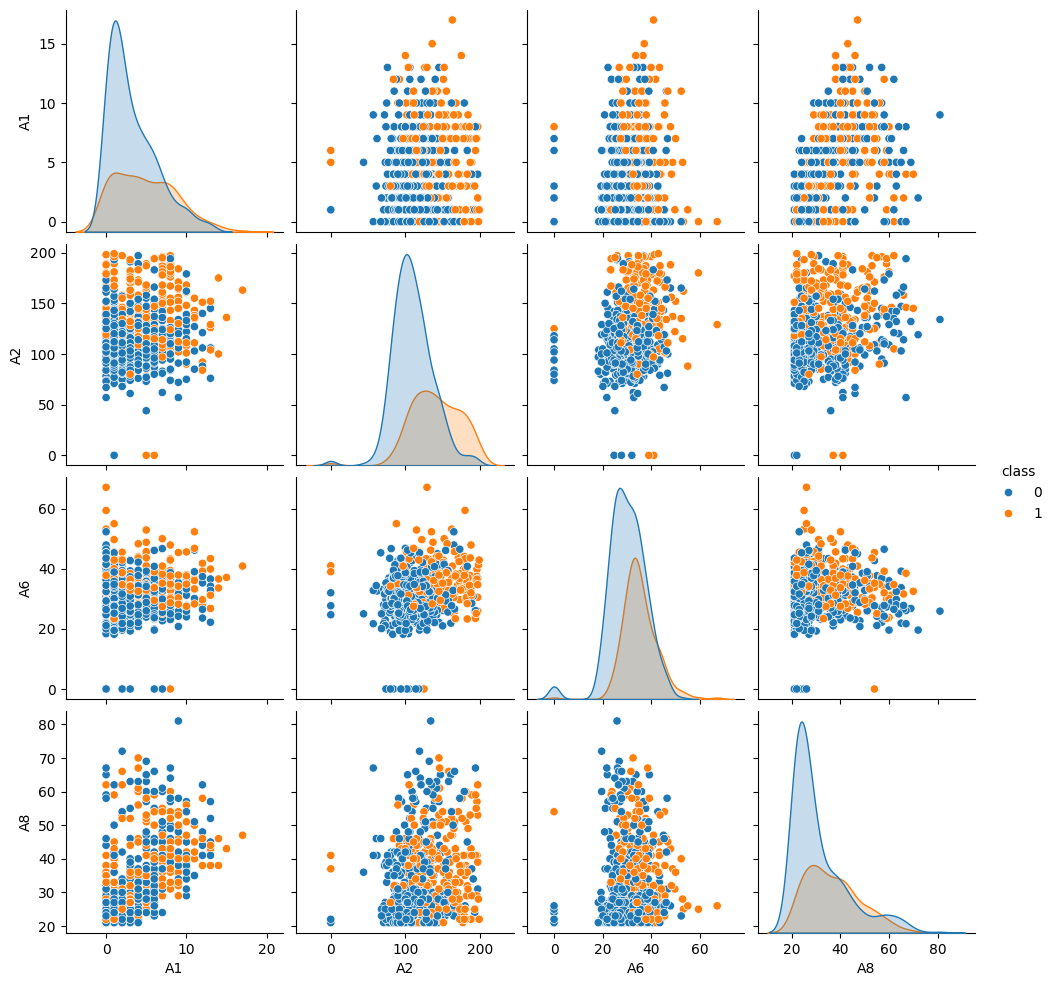

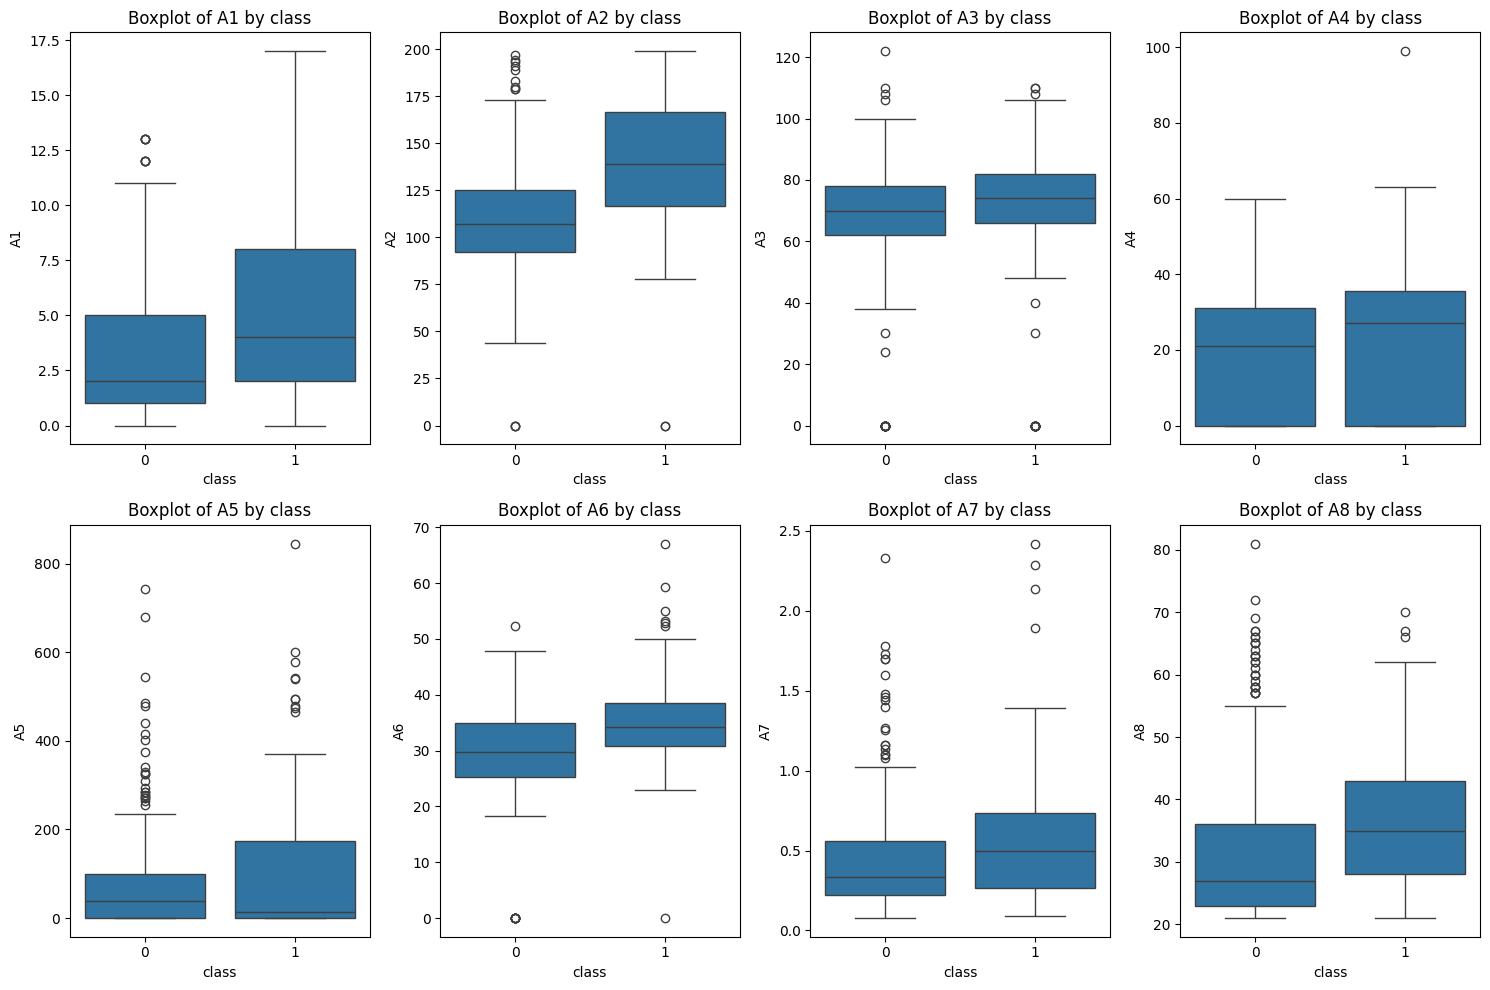

In [ ]:
# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Histograms for each feature
for i, column in enumerate(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8']):
    plt.subplot(2, 4, i+1)
    sns.histplot(data=train_df, x=column, hue='class', kde=True, bins=30)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = train_df.drop('id', axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Pairplot for key features
sns.pairplot(train_df[['A1', 'A2', 'A6', 'A8', 'class']], hue='class')
plt.show()

# Box plots to check for outliers
plt.figure(figsize=(15, 10))
for i, column in enumerate(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8']):
    plt.subplot(2, 4, i+1)
    sns.boxplot(data=train_df, y=column, x='class')
    plt.title(f'Boxplot of {column} by class')
plt.tight_layout()
plt.show()

In [ ]:
# Function to replace zero values with NaN for columns where zeros don't make sense
def replace_zeros_with_median(df, columns):
    df_processed = df.copy()

    for column in columns:
        # Calculate median for non-zero values
        median_value = df_processed[df_processed[column] != 0][column].median()

        # Replace zeros with the median
        df_processed.loc[df_processed[column] == 0, column] = median_value

    return df_processed

# Process training data
zero_sensitive_columns = ['A2', 'A3', 'A4', 'A5', 'A6']
train_processed = replace_zeros_with_median(train_df, zero_sensitive_columns)
test_processed = replace_zeros_with_median(test_df, zero_sensitive_columns)
train_processed.head()

,id,A1,A2,A3,A4,A5,A6,A7,A8,class
0,1,6,148,72,35,121,33.6,0.627,50,1
1,2,1,85,66,29,121,26.6,0.351,31,0
2,3,8,183,64,29,121,23.3,0.672,32,1
3,4,1,89,66,23,94,28.1,0.167,21,0
4,5,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
# Extract features and target
X_train = train_processed.drop(['id', 'class'], axis=1)
y_train = train_processed['class']
X_test = test_processed.drop(['id'], axis=1)
test_ids = test_processed['id']

# Split training data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train
)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Training data shape after processing:", X_train_scaled.shape)
print("Validation data shape after processing:", X_val_scaled.shape)
print("Test data shape after processing:", X_test_scaled.shape)

Training data shape after processing: (534, 8)
Validation data shape after processing: (134, 8)
Test data shape after processing: (100, 8)


In [ ]:
# # Apply SMOTE for class imbalance
# smote = SMOTE(random_state=SEED)
# X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train_split)

# print("Training data shape after SMOTE:", X_train_smote.shape)
# print("Class distribution after SMOTE:")
# print(np.bincount(y_train_smote))

Training data shape after SMOTE: (698, 8)
Class distribution after SMOTE:
[349 349]


In [ ]:
# Define a function to create an optimized model
def create_optimized_model(input_dim):
    # Initialize a Sequential model
    model = Sequential([
        # Input layer with L1L2 regularization
        Dense(128, input_dim=input_dim, activation='relu',
              kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        BatchNormalization(),
        Dropout(0.4),

        # Hidden layers with decreasing units
        Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        BatchNormalization(),
        Dropout(0.2),

        # Output layer
        Dense(1, activation='sigmoid')
    ])

    # Compile the model with a custom learning rate
    optimizer = Adam(learning_rate=0.0005)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create the model
input_dim = X_train_scaled.shape[1]
model = create_optimized_model(input_dim)

# Define callbacks for training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_diabetes_model.h5', monitor='val_accuracy',
                    save_best_only=True, mode='max', verbose=1)
]

# Train the model
history = model.fit(
    X_train_scaled, y_train_split,
    validation_data=(X_val_scaled, y_val),
    epochs=300,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/300
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5660 - auc_1: 0.5870 - loss: 0.8469 
Epoch 1: val_accuracy improved from -inf to 0.64179, saving model to best_diabetes_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.5725 - auc_1: 0.5921 - loss: 0.8398 - val_accuracy: 0.6418 - val_auc_1: 0.6813 - val_loss: 0.7005 - learning_rate: 5.0000e-04
Epoch 2/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5312 - auc_1: 0.5205 - loss: 0.9026
Epoch 2: val_accuracy did not improve from 0.64179
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6202 - auc_1: 0.6432 - loss: 0.7957 - val_accuracy: 0.6343 - val_auc_1: 0.7200 - val_loss: 0.6946 - learning_rate: 5.0000e-04
Epoch 3/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5312 - auc_1: 0.6227 - loss: 0.7953
Epoch 3: val_accuracy improved from 0.64179 to 0.64925, saving model to best_diabetes_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6494 - auc_1: 0.7157 - loss: 0.6899 - val_accuracy: 0.6493 - val_auc_1: 0.7427 - val_loss: 0.6911 - learning_rate: 5.0000e-04
Epoch 4/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.5625 - auc_1: 0.7273 - loss: 0.7202
Epoch 4: val_accuracy did not improve from 0.64925
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6793 - auc_1: 0.7774 - loss: 0.6213 - val_accuracy: 0.6418 - val_auc_1: 0.7479 - val_loss: 0.6834 - learning_rate: 5.0000e-04
Epoch 5/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7188 - auc_1: 0.7409 - loss: 0.6560
Epoch 5: val_accuracy improved from 0.64925 to 0.66418, saving model to best_diabetes_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7174 - auc_1: 0.7954 - loss: 0.6060 - val_accuracy: 0.6642 - val_auc_1: 0.7515 - val_loss: 0.6782 - learning_rate: 5.0000e-04
Epoch 6/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6250 - auc_1: 0.7841 - loss: 0.6144
Epoch 6: val_accuracy did not improve from 0.66418
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7225 - auc_1: 0.8156 - loss: 0.5795 - val_accuracy: 0.6343 - val_auc_1: 0.7528 - val_loss: 0.6797 - learning_rate: 5.0000e-04
Epoch 7/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6562 - auc_1: 0.7818 - loss: 0.5989
Epoch 7: val_accuracy did not improve from 0.66418
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7309 - auc_1: 0.8023 - loss: 0.5884 - val_accuracy: 0.6567 - val_auc_1: 0.7559 - val_loss: 0.6735 - learning_rate: 5.0000e-04
Epoch 8/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6875 - auc_1: 0.7568 - loss: 0.6033
Epoch 8: val_accuracy did not improve from 0.66418
17/1

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7206 - auc_1: 0.7973 - loss: 0.5847 - val_accuracy: 0.6866 - val_auc_1: 0.7689 - val_loss: 0.6553 - learning_rate: 5.0000e-04
Epoch 10/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.7500 - auc_1: 0.8227 - loss: 0.5263
Epoch 10: val_accuracy improved from 0.68657 to 0.70149, saving model to best_diabetes_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7664 - auc_1: 0.8154 - loss: 0.5532 - val_accuracy: 0.7015 - val_auc_1: 0.7719 - val_loss: 0.6474 - learning_rate: 5.0000e-04
Epoch 11/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - auc_1: 0.7523 - loss: 0.5650
Epoch 11: val_accuracy did not improve from 0.70149
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7539 - auc_1: 0.8202 - loss: 0.5289 - val_accuracy: 0.6940 - val_auc_1: 0.7732 - val_loss: 0.6412 - learning_rate: 5.0000e-04
Epoch 12/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7812 - auc_1: 0.8705 - loss: 0.4762
Epoch 12: val_accuracy did not improve from 0.70149
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7546 - auc_1: 0.8361 - loss: 0.5122 - val_accuracy: 0.7015 - val_auc_1: 0.7768 - val_loss: 0.6339 - learning_rate: 5.0000e-04
Epoch 13/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7188 - auc_1: 0.8409 - loss: 0.4803
Epoch 13: val_accuracy improved from 0.70149 to 0.

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7609 - auc_1: 0.8438 - loss: 0.5044 - val_accuracy: 0.7239 - val_auc_1: 0.7769 - val_loss: 0.6231 - learning_rate: 5.0000e-04
Epoch 14/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6562 - auc_1: 0.7727 - loss: 0.5756
Epoch 14: val_accuracy improved from 0.72388 to 0.73881, saving model to best_diabetes_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7425 - auc_1: 0.8150 - loss: 0.5494 - val_accuracy: 0.7388 - val_auc_1: 0.7799 - val_loss: 0.6107 - learning_rate: 5.0000e-04
Epoch 15/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8125 - auc_1: 0.9182 - loss: 0.3979
Epoch 15: val_accuracy improved from 0.73881 to 0.74627, saving model to best_diabetes_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7757 - auc_1: 0.8459 - loss: 0.4952 - val_accuracy: 0.7463 - val_auc_1: 0.7854 - val_loss: 0.6007 - learning_rate: 5.0000e-04
Epoch 16/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - auc_1: 0.7727 - loss: 0.5399
Epoch 16: val_accuracy did not improve from 0.74627
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7774 - auc_1: 0.8428 - loss: 0.4990 - val_accuracy: 0.7463 - val_auc_1: 0.7879 - val_loss: 0.5908 - learning_rate: 5.0000e-04
Epoch 17/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6875 - auc_1: 0.7477 - loss: 0.5554
Epoch 17: val_accuracy did not improve from 0.74627
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7565 - auc_1: 0.8342 - loss: 0.4981 - val_accuracy: 0.7388 - val_auc_1: 0.7906 - val_loss: 0.5878 - learning_rate: 5.0000e-04
Epoch 18/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7812 - auc_1: 0.7795 - loss: 0.5431
Epoch 18: val_accuracy did not improve from 0.7462

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7702 - auc_1: 0.8309 - loss: 0.5104 - val_accuracy: 0.7537 - val_auc_1: 0.7982 - val_loss: 0.5690 - learning_rate: 5.0000e-04
Epoch 26/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.7500 - auc_1: 0.8091 - loss: 0.5422
Epoch 26: val_accuracy did not improve from 0.75373
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7733 - auc_1: 0.8694 - loss: 0.4557 - val_accuracy: 0.7463 - val_auc_1: 0.7989 - val_loss: 0.5691 - learning_rate: 5.0000e-04
Epoch 27/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8125 - auc_1: 0.8045 - loss: 0.4731
Epoch 27: val_accuracy did not improve from 0.75373
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8248 - auc_1: 0.8708 - loss: 0.4460 - val_accuracy: 0.7463 - val_auc_1: 0.7974 - val_loss: 0.5712 - learning_rate: 5.0000e-04
Epoch 28/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7812 - auc_1: 0.8091 - loss: 0.4798
Epoch 28: val_accuracy did not improve from 0.753

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8239 - auc_1: 0.8908 - loss: 0.4211 - val_accuracy: 0.7612 - val_auc_1: 0.7971 - val_loss: 0.5985 - learning_rate: 1.2500e-04
Epoch 49/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7812 - auc_1: 0.8864 - loss: 0.3925
Epoch 49: val_accuracy did not improve from 0.76119
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8068 - auc_1: 0.8862 - loss: 0.4212 - val_accuracy: 0.7612 - val_auc_1: 0.7967 - val_loss: 0.5967 - learning_rate: 1.2500e-04
Epoch 49: early stopping
Restoring model weights from the end of the best epoch: 24.


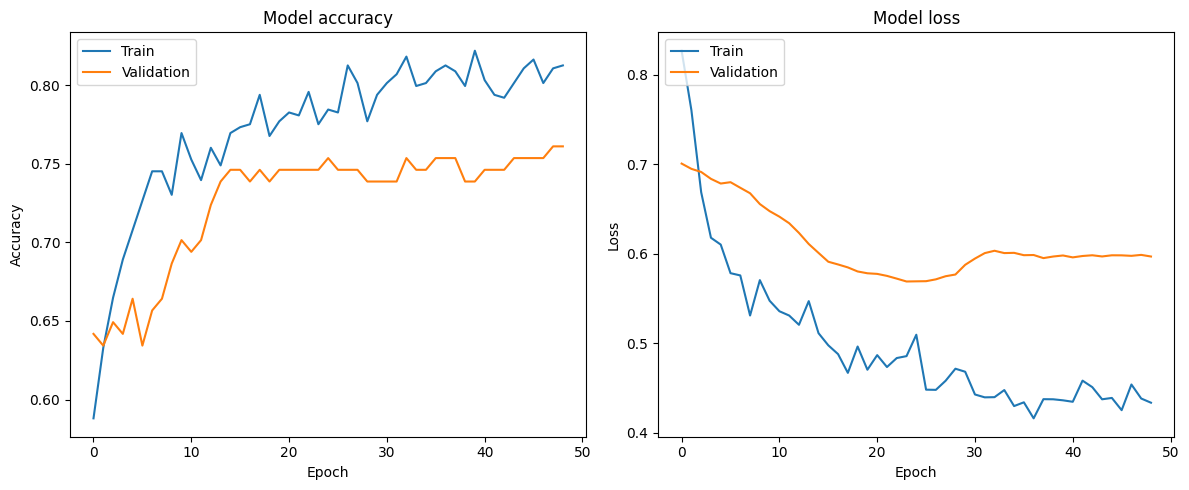

In [ ]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

Validation Loss: 0.5688
Validation Accuracy: 0.7463
Validation AUC: 0.7992
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


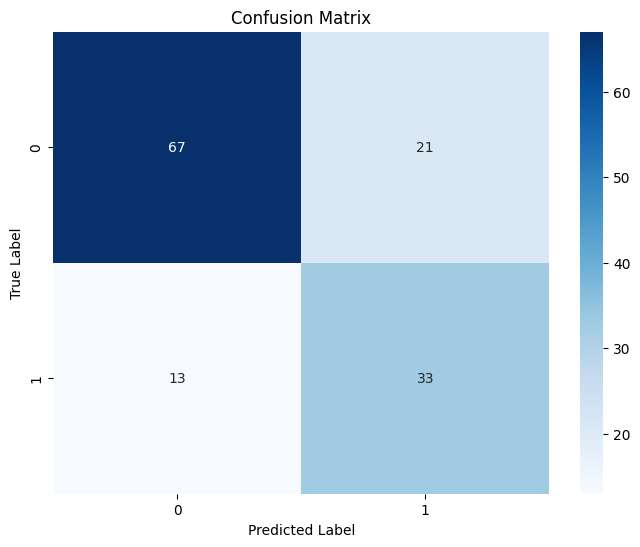

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.76      0.80        88
           1       0.61      0.72      0.66        46

    accuracy                           0.75       134
   macro avg       0.72      0.74      0.73       134
weighted avg       0.76      0.75      0.75       134



In [ ]:
# Evaluate the model on the validation set
val_loss, val_acc, val_auc = model.evaluate(X_val_scaled, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation AUC: {val_auc:.4f}")

# Make predictions on the validation set
y_val_pred_proba = model.predict(X_val_scaled).ravel()
y_val_pred = (y_val_pred_proba > 0.5).astype(int)

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print detailed classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

In [ ]:
# Let's create an ensemble of models using K-fold cross-validation
def ensemble_predict(X, models):
    predictions = np.zeros((X.shape[0],))
    for model in models:
        predictions += model.predict(X).ravel()
    return predictions / len(models)

# Initialize StratifiedKFold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

# Prepare containers for models and scores
ensemble_models = []
fold_scores = []

# Perform k-fold cross-validation
X_original = X_train.values
y_original = y_train.values

for fold, (train_idx, val_idx) in enumerate(skf.split(X_original, y_original)):
    print(f"\nTraining fold {fold+1}/{n_splits}")

    # Get the fold training and validation data
    X_fold_train, X_fold_val = X_original[train_idx], X_original[val_idx]
    y_fold_train, y_fold_val = y_original[train_idx], y_original[val_idx]

    # Scale the data
    fold_scaler = StandardScaler()
    X_fold_train_scaled = fold_scaler.fit_transform(X_fold_train)
    X_fold_val_scaled = fold_scaler.transform(X_fold_val)

    # Apply SMOTE
    fold_smote = SMOTE(random_state=SEED + fold)
    X_fold_train_smote, y_fold_train_smote = fold_smote.fit_resample(X_fold_train_scaled, y_fold_train)

    # Create and train the model
    fold_model = create_optimized_model(input_dim)

    fold_callbacks = [
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=0)
    ]

    fold_model.fit(
        X_fold_train_smote, y_fold_train_smote,
        validation_data=(X_fold_val_scaled, y_fold_val),
        epochs=200,
        batch_size=32,
        callbacks=fold_callbacks,
        verbose=0
    )

    # Evaluate the model
    fold_loss, fold_acc, fold_auc = fold_model.evaluate(X_fold_val_scaled, y_fold_val, verbose=0)
    fold_scores.append(fold_acc)
    print(f"Fold {fold+1} Accuracy: {fold_acc:.4f}")

    # Store the model for ensemble prediction
    ensemble_models.append(fold_model)

# Display cross-validation results
print(f"\nCross-validation accuracy scores: {fold_scores}")
print(f"Mean accuracy: {np.mean(fold_scores):.4f} (±{np.std(fold_scores):.4f})")

# Scale test data using the last fold scaler (or you can use the original scaler)
X_test_ensemble_scaled = fold_scaler.transform(X_test)

# Make ensemble predictions on the test set
test_predictions_proba = ensemble_predict(X_test_ensemble_scaled, ensemble_models)
test_predictions = (test_predictions_proba > 0.5).astype(int)

# Create submission dataframe
submission_df = pd.DataFrame({
    'id': test_ids,
    'prediction': test_predictions
})

# Save predictions to CSV
submission_df.to_csv('test-predictions.csv', index=False)
print("Predictions saved to 'test-predictions.csv'")


Training fold 1/5
Fold 1 Accuracy: 0.7015

Training fold 2/5
Fold 2 Accuracy: 0.7313

Training fold 3/5
Fold 3 Accuracy: 0.7388

Training fold 4/5
Fold 4 Accuracy: 0.6842

Training fold 5/5
Fold 5 Accuracy: 0.7519

Cross-validation accuracy scores: [0.7014925479888916, 0.7313432693481445, 0.7388059496879578, 0.6842105388641357, 0.7518796920776367]
Mean accuracy: 0.7215 (±0.0249)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predictions saved to 'test-predictions.csv'


In [ ]:
# Install Keras Tuner if not already installed
!pip install -q keras-tuner

import keras_tuner as kt

# Define the model-building function for hyperparameter tuning
def build_tuning_model(hp):
    model = Sequential()

    # First layer
    model.add(Dense(
        units=hp.Int('units_1', min_value=32, max_value=256, step=32),
        activation=hp.Choice('activation_1', values=['relu', 'elu', 'selu']),
        kernel_regularizer=l1_l2(
            l1=hp.Float('l1_1', min_value=1e-6, max_value=1e-3, sampling='log'),
            l2=hp.Float('l2_1', min_value=1e-6, max_value=1e-3, sampling='log')
        ),
        input_dim=X_train_scaled.shape[1]
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

    # Number of hidden layers
    for i in range(hp.Int('num_hidden_layers', 1, 3)):
        model.add(Dense(
            units=hp.Int(f'units_{i+2}', min_value=16, max_value=128, step=16),
            activation=hp.Choice(f'activation_{i+2}', values=['relu', 'elu', 'selu']),
            kernel_regularizer=l1_l2(
                l1=hp.Float(f'l1_{i+2}', min_value=1e-6, max_value=1e-3, sampling='log'),
                l2=hp.Float(f'l2_{i+2}', min_value=1e-6, max_value=1e-3, sampling='log')
            )
        ))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float(f'dropout_{i+2}', min_value=0.1, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')

    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    else:
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Initialize the Hyperband tuner
tuner = kt.Hyperband(
    build_tuning_model,
    objective='val_accuracy',
    max_epochs=150,
    factor=3,
    directory='keras_tuner_dir',
    project_name='diabetes_prediction'
)

# Define early stopping callback for the tuner
stop_early = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Run the hyperparameter search
tuner.search(
    X_train_smote, y_train_smote,
    validation_data=(X_val_scaled, y_val),
    epochs=150,
    batch_size=32,
    callbacks=[stop_early]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history_best = best_model.fit(
    X_train_smote, y_train_smote,
    validation_data=(X_val_scaled, y_val),
    epochs=300,
    batch_size=32,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-6, verbose=1),
        ModelCheckpoint('best_tuned_diabetes_model.h5', monitor='val_accuracy',
                        save_best_only=True, mode='max', verbose=1)
    ],
    verbose=1
)

# Evaluate the best model
best_val_loss, best_val_acc, best_val_auc = best_model.evaluate(X_val_scaled, y_val, verbose=0)
print(f"Best Model Validation Loss: {best_val_loss:.4f}")
print(f"Best Model Validation Accuracy: {best_val_acc:.4f}")
print(f"Best Model Validation AUC: {best_val_auc:.4f}")

# Make predictions on the test set with the best model
test_predictions_best_proba = best_model.predict(X_test_scaled).ravel()
test_predictions_best = (test_predictions_best_proba > 0.5).astype(int)

# Create final submission dataframe
final_submission_df = pd.DataFrame({
    'id': test_ids,
    'prediction': test_predictions_best
})

# Save final predictions to CSV
final_submission_df.to_csv('test-predictions-best.csv', index=False)
print("Best model predictions saved to 'test-predictions-best.csv'")

Trial 123 Complete [00h 00m 10s]
val_accuracy: 0.746268630027771

Best val_accuracy So Far: 0.7761194109916687
Total elapsed time: 00h 16m 26s

Search: Running Trial #124

Value             |Best Value So Far |Hyperparameter
256               |192               |units_1
selu              |elu               |activation_1
5.9895e-05        |0.00013635        |l1_1
0.00067621        |3.1888e-06        |l2_1
0.4               |0.1               |dropout_1
3                 |1                 |num_hidden_layers
16                |128               |units_2
relu              |relu              |activation_2
6.8827e-06        |1.3463e-06        |l1_2
6.4605e-05        |0.00041385        |l2_2
0.1               |0.4               |dropout_2
0.0079863         |0.00015359        |learning_rate
adam              |adam              |optimizer
112               |112               |units_3
elu               |selu              |activation_3
5.6919e-06        |1.9915e-06        |l1_3
5.5316e-06       

In [ ]:
from tensorflow.keras import backend as K
from tensorflow import keras

# Clear session to free memory
keras.backend.clear_session()

# set random seed
# keras.utils.set_random_seed(seed) # set all random seeds for the program (Python, NumPy, and TensorFlow)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Load data
df = pd.read_csv('https://drive.google.com/uc?export=download&id=1M4MTBKUaR4aA8hjINEGhfShBZ18ctZA-')
# test_df = pd.read_csv('https://drive.google.com/uc?export=download&id=1BhfC5yBThGkAdkxbf7kEVZFjsysVYXqP')
X = df.drop(['id', 'class'], axis=1).values
y = df['class'].values

# Split data (stratified)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Preprocessing
def preprocess(X_train, X_val):
    cols_to_impute = [1, 2, 3, 4, 5]  # Indices for A2-A6
    for col in cols_to_impute:
        median = np.median(X_train[X_train[:, col] != 0][:, col])
        X_train[:, col] = np.where(X_train[:, col] == 0, median, X_train[:, col])
        X_val[:, col] = np.where(X_val[:, col] == 0, median, X_val[:, col])
    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    return X_train, X_val

X_train, X_val = preprocess(X_train, X_val)

# Build model
model = Sequential([
    Dense(64, activation='relu', input_dim=8, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train with class weights
# class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)
# class_weights = {0: class_weights[0], 1: class_weights[1]}

history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[EarlyStopping(patience=20)],
    # class_weight=class_weights,
    verbose=1
)

# Evaluate
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

Epoch 1/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5588 - loss: 0.8354 - val_accuracy: 0.6493 - val_loss: 0.8240
Epoch 2/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6425 - loss: 0.7949 - val_accuracy: 0.7090 - val_loss: 0.7604
Epoch 3/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6319 - loss: 0.7721 - val_accuracy: 0.6940 - val_loss: 0.7358
Epoch 4/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6378 - loss: 0.7401 - val_accuracy: 0.6866 - val_loss: 0.7299
Epoch 5/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6320 - loss: 0.7330 - val_accuracy: 0.6866 - val_loss: 0.7257
Epoch 6/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6682 - loss: 0.7386 - val_accuracy: 0.6716 - val_loss: 0.7182
Epoch 7/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6552 - loss: 0.7355 - val_accuracy: 0.6716 - val_loss: 0.7143
Epoch 8/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6345 - loss: 0.7708 - val_accuracy: 0.6716 - v

In [ ]:
keras.backend.clear_session()

In [ ]:
# Importing all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.initializers import HeUniform, GlorotUniform

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load datasets
train_df = pd.read_csv('https://drive.google.com/uc?export=download&id=1M4MTBKUaR4aA8hjINEGhfShBZ18ctZA-')
test_df = pd.read_csv('https://drive.google.com/uc?export=download&id=1BhfC5yBThGkAdkxbf7kEVZFjsysVYXqP')

# Display basic information about the dataset
print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)
print("\nClass distribution:")
print(train_df['class'].value_counts())
print(train_df['class'].value_counts(normalize=True))

# Check for missing values (zeros in medical data often indicate missing values)
print("\nNumber of zeros in each column of training data:")
for col in ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8']:
    zeros = (train_df[col] == 0).sum()
    print(f"{col}: {zeros} zeros ({zeros/len(train_df)*100:.2f}%)")

Training data shape: (668, 10)
Test data shape: (100, 9)

Class distribution:
class
0    437
1    231
Name: count, dtype: int64
class
0    0.654192
1    0.345808
Name: proportion, dtype: float64

Number of zeros in each column of training data:
A1: 102 zeros (15.27%)
A2: 5 zeros (0.75%)
A3: 32 zeros (4.79%)
A4: 196 zeros (29.34%)
A5: 322 zeros (48.20%)
A6: 9 zeros (1.35%)
A7: 0 zeros (0.00%)
A8: 0 zeros (0.00%)


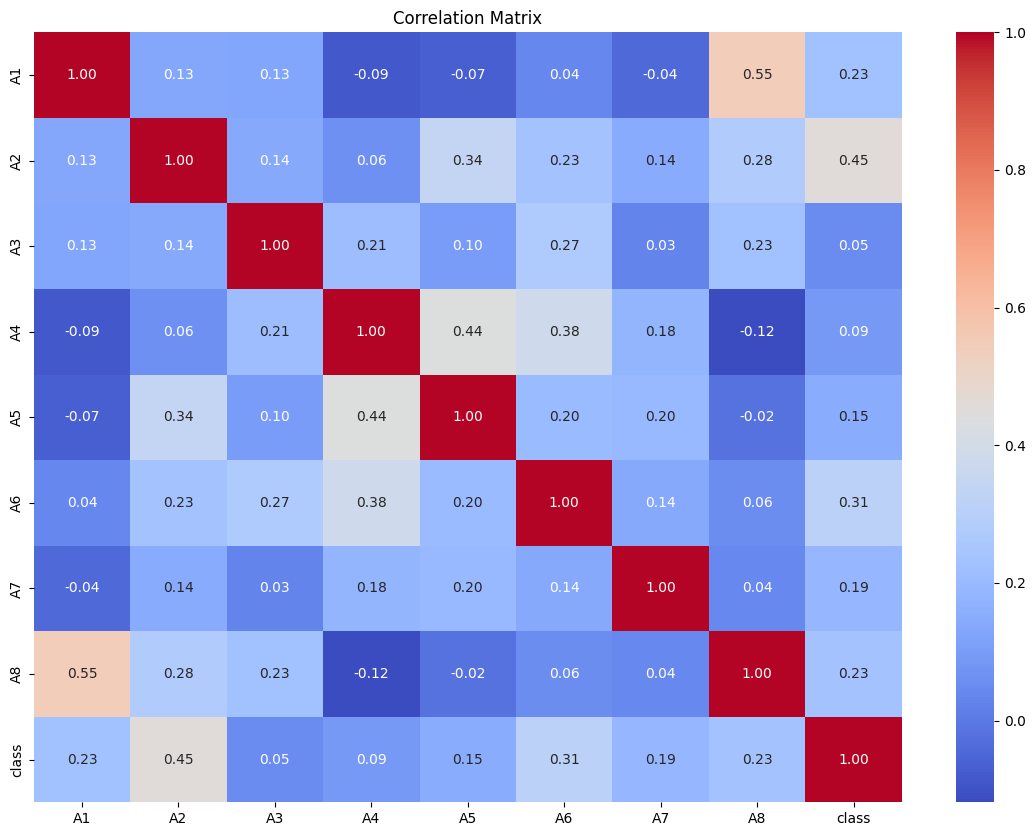

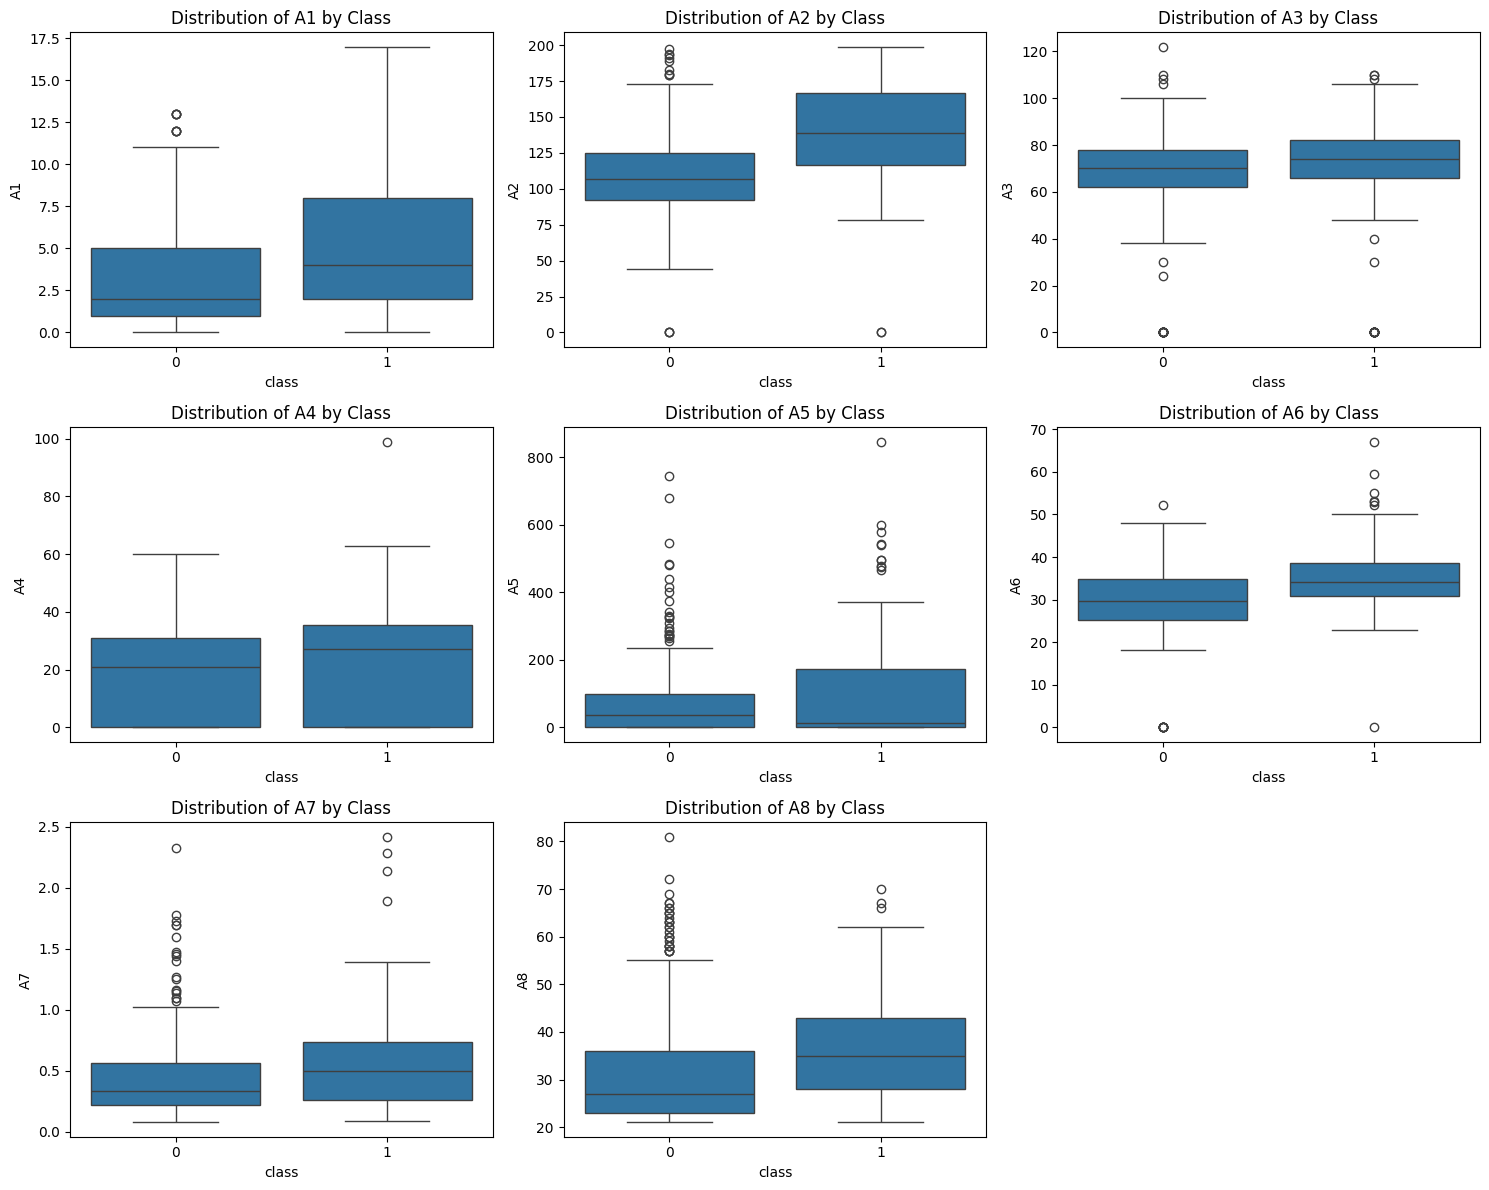

After SMOTE: (874, 15)
Training set shape: (699, 15)
Validation set shape: (175, 15)
Training class distribution: [349 350]
Validation class distribution: [88 87]


In [ ]:
# Data visualization and analysis
plt.figure(figsize=(14, 10))
sns.heatmap(train_df.drop('id', axis=1).corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Visualize feature distributions by class
features = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8']
plt.figure(figsize=(15, 12))
for i, feature in enumerate(features):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x='class', y=feature, data=train_df)
    plt.title(f'Distribution of {feature} by Class')
plt.tight_layout()
plt.show()

# Improved data preprocessing function
def preprocess_data(train_df, test_df, use_synthetic=True):
    """
    Comprehensive preprocessing strategy including:
    - Handling missing values (zeros)
    - Feature scaling
    - Feature engineering
    - Optional synthetic samples for imbalanced classes
    """
    # Make copies to avoid modifying originals
    train = train_df.copy()
    test = test_df.copy()

    # 1. Handle missing values (zeros) in training data
    # For A1 (pregnancies), zero can be valid for someone who has never been pregnant
    # For other medical measurements, zeros likely indicate missing data

    for feature in ['A2', 'A3', 'A4', 'A5', 'A6']:
        # Create masks for zero values
        mask_train = train[feature] == 0

        if feature == 'A2':  # Glucose
            # For glucose, use class-specific median (critical for diabetes)
            class0_median = train.loc[(train['class'] == 0) & (train[feature] > 0), feature].median()
            class1_median = train.loc[(train['class'] == 1) & (train[feature] > 0), feature].median()

            train.loc[(mask_train) & (train['class'] == 0), feature] = class0_median
            train.loc[(mask_train) & (train['class'] == 1), feature] = class1_median

            # For test data, use overall training median since we don't know class
            mask_test = test[feature] == 0
            test.loc[mask_test, feature] = train.loc[train[feature] > 0, feature].median()

        else:
            # For other features, use class and feature-specific medians
            class0_median = train.loc[(train['class'] == 0) & (train[feature] > 0), feature].median()
            class1_median = train.loc[(train['class'] == 1) & (train[feature] > 0), feature].median()

            train.loc[(mask_train) & (train['class'] == 0), feature] = class0_median
            train.loc[(mask_train) & (train['class'] == 1), feature] = class1_median

            # For test data
            mask_test = test[feature] == 0
            test.loc[mask_test, feature] = train.loc[train[feature] > 0, feature].median()

    # 2. Feature engineering
    # Create interaction features
    train['BMI_Age'] = train['A6'] * train['A8'] / 100  # BMI-Age interaction
    test['BMI_Age'] = test['A6'] * test['A8'] / 100

    train['Glucose_BMI'] = train['A2'] * train['A6'] / 100  # Glucose-BMI interaction
    test['Glucose_BMI'] = test['A2'] * test['A6'] / 100

    train['Glucose_Age'] = train['A2'] * train['A8'] / 100  # Glucose-Age interaction
    test['Glucose_Age'] = test['A2'] * test['A8'] / 100

    # Add polynomial features for strongest predictors
    train['Glucose_squared'] = train['A2'] ** 2
    test['Glucose_squared'] = test['A2'] ** 2

    train['BMI_squared'] = train['A6'] ** 2
    test['BMI_squared'] = test['A6'] ** 2

    # 3. Log transform for skewed features
    for feature in ['A5', 'A7']:  # Insulin and DiabetesPedigreeFunction are skewed
        train[feature + '_log'] = np.log1p(train[feature])
        test[feature + '_log'] = np.log1p(test[feature])

    # 4. Prepare final datasets
    X_train = train.drop(['id', 'class'], axis=1)
    y_train = train['class']
    X_test = test.drop(['id'], axis=1)

    # 5. Feature scaling
    power_transformer = PowerTransformer(method='yeo-johnson')
    X_train_scaled = power_transformer.fit_transform(X_train)
    X_test_scaled = power_transformer.transform(X_test)

    # 6. Synthetic Minority Oversampling Technique (SMOTE) for imbalanced data
    if use_synthetic and sum(y_train == 1) < sum(y_train == 0):
        from imblearn.over_sampling import SMOTE
        smote = SMOTE(random_state=42)
        X_train_scaled, y_train = smote.fit_resample(X_train_scaled, y_train)
        print(f"After SMOTE: {X_train_scaled.shape}")

    return X_train_scaled, y_train, X_test_scaled, X_train.columns.tolist()

# Apply preprocessing
X_train_scaled, y_train, X_test_scaled, feature_names = preprocess_data(train_df, test_df)

# Split data into training and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_scaled, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train  # Ensure class distribution is maintained
)

print("Training set shape:", X_train_final.shape)
print("Validation set shape:", X_val.shape)
print("Training class distribution:", np.bincount(y_train_final))
print("Validation class distribution:", np.bincount(y_val))


Training fold 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(



Epoch 1: val_accuracy improved from -inf to 0.64571, saving model to best_diabetes_model.h5



Epoch 2: val_accuracy improved from 0.64571 to 0.81143, saving model to best_diabetes_model.h5



Epoch 3: val_accuracy improved from 0.81143 to 0.87429, saving model to best_diabetes_model.h5



Epoch 4: val_accuracy did not improve from 0.87429

Epoch 5: val_accuracy did not improve from 0.87429

Epoch 6: val_accuracy did not improve from 0.87429

Epoch 7: val_accuracy did not improve from 0.87429

Epoch 8: val_accuracy did not improve from 0.87429

Epoch 9: val_accuracy did not improve from 0.87429

Epoch 10: val_accuracy did not improve from 0.87429

Epoch 11: val_accuracy did not improve from 0.87429

Epoch 12: val_accuracy did not improve from 0.87429

Epoch 13: ReduceLROnPlateau reducing learning rate to 6.000000284984708e-05.

Epoch 13: val_accuracy did not improve from 0.87429

Epoch 14: val_accuracy did not improve from 0.87429

Epoch 15: val_accuracy did not improve from 0.87429

Epoch 16: val_accuracy did not improve from 0.87429

Epoch 17: val_accuracy did not improve from 0.87429

Epoch 18: val_accuracy did not improve from 0.87429

Epoch 19: val_accuracy did not improve from 0.87429

Epoch 20: val_accuracy did not improve from 0.87429

Epoch 21: val_accuracy did

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(



Epoch 1: val_accuracy improved from -inf to 0.50857, saving model to best_diabetes_model.h5



Epoch 2: val_accuracy improved from 0.50857 to 0.58857, saving model to best_diabetes_model.h5



Epoch 3: val_accuracy improved from 0.58857 to 0.62286, saving model to best_diabetes_model.h5



Epoch 4: val_accuracy improved from 0.62286 to 0.68000, saving model to best_diabetes_model.h5



Epoch 5: val_accuracy improved from 0.68000 to 0.74857, saving model to best_diabetes_model.h5



Epoch 6: val_accuracy improved from 0.74857 to 0.78286, saving model to best_diabetes_model.h5



Epoch 7: val_accuracy improved from 0.78286 to 0.79429, saving model to best_diabetes_model.h5



Epoch 8: val_accuracy improved from 0.79429 to 0.80571, saving model to best_diabetes_model.h5



Epoch 9: val_accuracy improved from 0.80571 to 0.81714, saving model to best_diabetes_model.h5



Epoch 10: val_accuracy did not improve from 0.81714

Epoch 11: val_accuracy did not improve from 0.81714

Epoch 12: val_accuracy did not improve from 0.81714

Epoch 13: val_accuracy improved from 0.81714 to 0.84000, saving model to best_diabetes_model.h5



Epoch 14: val_accuracy did not improve from 0.84000

Epoch 15: val_accuracy did not improve from 0.84000

Epoch 16: val_accuracy improved from 0.84000 to 0.85143, saving model to best_diabetes_model.h5



Epoch 17: val_accuracy improved from 0.85143 to 0.85714, saving model to best_diabetes_model.h5



Epoch 18: val_accuracy improved from 0.85714 to 0.86286, saving model to best_diabetes_model.h5



Epoch 19: val_accuracy did not improve from 0.86286

Epoch 20: val_accuracy did not improve from 0.86286

Epoch 21: val_accuracy did not improve from 0.86286

Epoch 22: val_accuracy did not improve from 0.86286

Epoch 23: val_accuracy did not improve from 0.86286

Epoch 24: val_accuracy did not improve from 0.86286

Epoch 25: val_accuracy did not improve from 0.86286

Epoch 26: val_accuracy did not improve from 0.86286

Epoch 27: val_accuracy did not improve from 0.86286

Epoch 28: ReduceLROnPlateau reducing learning rate to 6.000000284984708e-05.

Epoch 28: val_accuracy did not improve from 0.86286

Epoch 29: val_accuracy did not improve from 0.86286

Epoch 30: val_accuracy did not improve from 0.86286

Epoch 31: val_accuracy did not improve from 0.86286

Epoch 32: val_accuracy did not improve from 0.86286

Epoch 33: val_accuracy did not improve from 0.86286

Epoch 34: val_accuracy did not improve from 0.86286

Epoch 35: val_accuracy did not improve from 0.86286

Epoch 36: val_accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(



Epoch 1: val_accuracy improved from -inf to 0.71429, saving model to best_diabetes_model.h5



Epoch 2: val_accuracy improved from 0.71429 to 0.73714, saving model to best_diabetes_model.h5



Epoch 3: val_accuracy improved from 0.73714 to 0.74286, saving model to best_diabetes_model.h5



Epoch 4: val_accuracy did not improve from 0.74286

Epoch 5: val_accuracy did not improve from 0.74286

Epoch 6: val_accuracy improved from 0.74286 to 0.74857, saving model to best_diabetes_model.h5



Epoch 7: val_accuracy improved from 0.74857 to 0.76571, saving model to best_diabetes_model.h5



Epoch 8: val_accuracy did not improve from 0.76571

Epoch 9: val_accuracy did not improve from 0.76571

Epoch 10: val_accuracy did not improve from 0.76571

Epoch 11: val_accuracy did not improve from 0.76571

Epoch 12: val_accuracy did not improve from 0.76571

Epoch 13: val_accuracy improved from 0.76571 to 0.77143, saving model to best_diabetes_model.h5



Epoch 14: val_accuracy improved from 0.77143 to 0.77714, saving model to best_diabetes_model.h5



Epoch 15: val_accuracy improved from 0.77714 to 0.78286, saving model to best_diabetes_model.h5



Epoch 16: val_accuracy improved from 0.78286 to 0.78857, saving model to best_diabetes_model.h5



Epoch 17: val_accuracy improved from 0.78857 to 0.79429, saving model to best_diabetes_model.h5



Epoch 18: val_accuracy did not improve from 0.79429

Epoch 19: val_accuracy improved from 0.79429 to 0.80000, saving model to best_diabetes_model.h5



Epoch 20: val_accuracy improved from 0.80000 to 0.80571, saving model to best_diabetes_model.h5



Epoch 21: val_accuracy did not improve from 0.80571

Epoch 22: val_accuracy improved from 0.80571 to 0.81143, saving model to best_diabetes_model.h5



Epoch 23: val_accuracy improved from 0.81143 to 0.81714, saving model to best_diabetes_model.h5



Epoch 24: val_accuracy improved from 0.81714 to 0.82286, saving model to best_diabetes_model.h5



Epoch 25: val_accuracy did not improve from 0.82286

Epoch 26: val_accuracy did not improve from 0.82286

Epoch 27: val_accuracy did not improve from 0.82286

Epoch 28: val_accuracy improved from 0.82286 to 0.82857, saving model to best_diabetes_model.h5



Epoch 29: val_accuracy improved from 0.82857 to 0.84000, saving model to best_diabetes_model.h5



Epoch 30: val_accuracy improved from 0.84000 to 0.84571, saving model to best_diabetes_model.h5



Epoch 31: val_accuracy did not improve from 0.84571

Epoch 32: val_accuracy improved from 0.84571 to 0.85143, saving model to best_diabetes_model.h5



Epoch 33: val_accuracy did not improve from 0.85143

Epoch 34: val_accuracy did not improve from 0.85143

Epoch 35: val_accuracy improved from 0.85143 to 0.85714, saving model to best_diabetes_model.h5



Epoch 36: val_accuracy did not improve from 0.85714

Epoch 37: val_accuracy did not improve from 0.85714

Epoch 38: val_accuracy did not improve from 0.85714

Epoch 39: val_accuracy did not improve from 0.85714

Epoch 40: val_accuracy did not improve from 0.85714

Epoch 41: val_accuracy did not improve from 0.85714

Epoch 42: val_accuracy did not improve from 0.85714

Epoch 43: val_accuracy did not improve from 0.85714

Epoch 44: val_accuracy did not improve from 0.85714

Epoch 45: ReduceLROnPlateau reducing learning rate to 6.000000284984708e-05.

Epoch 45: val_accuracy did not improve from 0.85714

Epoch 46: val_accuracy did not improve from 0.85714

Epoch 47: val_accuracy did not improve from 0.85714

Epoch 48: val_accuracy did not improve from 0.85714

Epoch 49: val_accuracy did not improve from 0.85714

Epoch 50: val_accuracy did not improve from 0.85714

Epoch 51: val_accuracy did not improve from 0.85714

Epoch 52: val_accuracy did not improve from 0.85714

Epoch 53: val_accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(



Epoch 1: val_accuracy improved from -inf to 0.46286, saving model to best_diabetes_model.h5



Epoch 2: val_accuracy improved from 0.46286 to 0.56000, saving model to best_diabetes_model.h5



Epoch 3: val_accuracy improved from 0.56000 to 0.66286, saving model to best_diabetes_model.h5



Epoch 4: val_accuracy improved from 0.66286 to 0.72571, saving model to best_diabetes_model.h5



Epoch 5: val_accuracy improved from 0.72571 to 0.73714, saving model to best_diabetes_model.h5



Epoch 6: val_accuracy improved from 0.73714 to 0.74286, saving model to best_diabetes_model.h5



Epoch 7: val_accuracy improved from 0.74286 to 0.74857, saving model to best_diabetes_model.h5



Epoch 8: val_accuracy improved from 0.74857 to 0.76571, saving model to best_diabetes_model.h5



Epoch 9: val_accuracy improved from 0.76571 to 0.77714, saving model to best_diabetes_model.h5



Epoch 10: val_accuracy improved from 0.77714 to 0.78286, saving model to best_diabetes_model.h5



Epoch 11: val_accuracy improved from 0.78286 to 0.80571, saving model to best_diabetes_model.h5



Epoch 12: val_accuracy improved from 0.80571 to 0.81143, saving model to best_diabetes_model.h5



Epoch 13: val_accuracy improved from 0.81143 to 0.81714, saving model to best_diabetes_model.h5



Epoch 14: val_accuracy did not improve from 0.81714

Epoch 15: val_accuracy did not improve from 0.81714

Epoch 16: val_accuracy improved from 0.81714 to 0.82286, saving model to best_diabetes_model.h5



Epoch 17: val_accuracy did not improve from 0.82286

Epoch 18: val_accuracy did not improve from 0.82286

Epoch 19: val_accuracy did not improve from 0.82286

Epoch 20: val_accuracy did not improve from 0.82286

Epoch 21: val_accuracy improved from 0.82286 to 0.82857, saving model to best_diabetes_model.h5



Epoch 22: val_accuracy improved from 0.82857 to 0.83429, saving model to best_diabetes_model.h5



Epoch 23: val_accuracy improved from 0.83429 to 0.84000, saving model to best_diabetes_model.h5



Epoch 24: val_accuracy did not improve from 0.84000

Epoch 25: val_accuracy did not improve from 0.84000

Epoch 26: val_accuracy did not improve from 0.84000

Epoch 27: val_accuracy improved from 0.84000 to 0.84571, saving model to best_diabetes_model.h5



Epoch 28: val_accuracy did not improve from 0.84571

Epoch 29: val_accuracy did not improve from 0.84571

Epoch 30: val_accuracy did not improve from 0.84571

Epoch 31: val_accuracy did not improve from 0.84571

Epoch 32: val_accuracy did not improve from 0.84571

Epoch 33: val_accuracy improved from 0.84571 to 0.85143, saving model to best_diabetes_model.h5



Epoch 34: val_accuracy did not improve from 0.85143

Epoch 35: val_accuracy did not improve from 0.85143

Epoch 36: val_accuracy did not improve from 0.85143

Epoch 37: val_accuracy did not improve from 0.85143

Epoch 38: val_accuracy did not improve from 0.85143

Epoch 39: val_accuracy did not improve from 0.85143

Epoch 40: val_accuracy did not improve from 0.85143

Epoch 41: val_accuracy improved from 0.85143 to 0.85714, saving model to best_diabetes_model.h5



Epoch 42: val_accuracy did not improve from 0.85714

Epoch 43: val_accuracy did not improve from 0.85714

Epoch 44: val_accuracy did not improve from 0.85714

Epoch 45: val_accuracy did not improve from 0.85714

Epoch 46: val_accuracy improved from 0.85714 to 0.86286, saving model to best_diabetes_model.h5



Epoch 47: val_accuracy did not improve from 0.86286

Epoch 48: val_accuracy did not improve from 0.86286

Epoch 49: val_accuracy did not improve from 0.86286

Epoch 50: val_accuracy did not improve from 0.86286

Epoch 51: val_accuracy did not improve from 0.86286

Epoch 52: val_accuracy did not improve from 0.86286

Epoch 53: val_accuracy did not improve from 0.86286

Epoch 54: val_accuracy did not improve from 0.86286

Epoch 55: val_accuracy did not improve from 0.86286

Epoch 56: ReduceLROnPlateau reducing learning rate to 6.000000284984708e-05.

Epoch 56: val_accuracy did not improve from 0.86286

Epoch 57: val_accuracy did not improve from 0.86286

Epoch 58: val_accuracy did not improve from 0.86286

Epoch 59: val_accuracy did not improve from 0.86286

Epoch 60: val_accuracy did not improve from 0.86286

Epoch 61: val_accuracy did not improve from 0.86286

Epoch 62: val_accuracy did not improve from 0.86286

Epoch 63: val_accuracy did not improve from 0.86286

Epoch 64: val_accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(



Epoch 1: val_accuracy improved from -inf to 0.57471, saving model to best_diabetes_model.h5



Epoch 2: val_accuracy improved from 0.57471 to 0.70115, saving model to best_diabetes_model.h5



Epoch 3: val_accuracy improved from 0.70115 to 0.75287, saving model to best_diabetes_model.h5



Epoch 4: val_accuracy improved from 0.75287 to 0.76437, saving model to best_diabetes_model.h5



Epoch 5: val_accuracy improved from 0.76437 to 0.78736, saving model to best_diabetes_model.h5



Epoch 6: val_accuracy improved from 0.78736 to 0.79310, saving model to best_diabetes_model.h5



Epoch 7: val_accuracy improved from 0.79310 to 0.81034, saving model to best_diabetes_model.h5



Epoch 8: val_accuracy improved from 0.81034 to 0.81609, saving model to best_diabetes_model.h5



Epoch 9: val_accuracy improved from 0.81609 to 0.82184, saving model to best_diabetes_model.h5



Epoch 10: val_accuracy did not improve from 0.82184

Epoch 11: val_accuracy did not improve from 0.82184

Epoch 12: val_accuracy did not improve from 0.82184

Epoch 13: val_accuracy did not improve from 0.82184

Epoch 14: val_accuracy improved from 0.82184 to 0.83333, saving model to best_diabetes_model.h5



Epoch 15: val_accuracy did not improve from 0.83333

Epoch 16: val_accuracy did not improve from 0.83333

Epoch 17: val_accuracy did not improve from 0.83333

Epoch 18: val_accuracy did not improve from 0.83333

Epoch 19: val_accuracy did not improve from 0.83333

Epoch 20: val_accuracy did not improve from 0.83333

Epoch 21: val_accuracy did not improve from 0.83333

Epoch 22: val_accuracy did not improve from 0.83333

Epoch 23: val_accuracy did not improve from 0.83333

Epoch 24: ReduceLROnPlateau reducing learning rate to 6.000000284984708e-05.

Epoch 24: val_accuracy did not improve from 0.83333

Epoch 25: val_accuracy did not improve from 0.83333

Epoch 26: val_accuracy did not improve from 0.83333

Epoch 27: val_accuracy did not improve from 0.83333

Epoch 28: val_accuracy did not improve from 0.83333

Epoch 29: val_accuracy did not improve from 0.83333

Epoch 30: val_accuracy did not improve from 0.83333

Epoch 31: val_accuracy did not improve from 0.83333

Epoch 32: val_accura

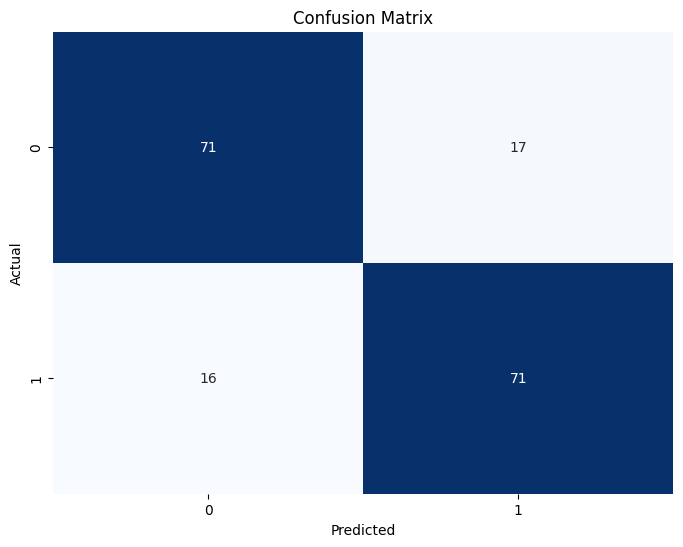

In [ ]:
# Function to create and compile the model
def create_advanced_model(input_dim, learning_rate=0.0003):
    """Create an advanced neural network with best practices for medical data classification"""

    # Initialize with a kernel initializer that works well with ReLU/LeakyReLU
    initializer = HeUniform(seed=42)

    model = Sequential([
        # Input layer
        Dense(64, input_dim=input_dim,
              kernel_initializer=initializer,
              kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001)),
        LeakyReLU(alpha=0.1),  # LeakyReLU often works better than ReLU
        BatchNormalization(),  # Helps stabilize training
        Dropout(0.3),

        # Hidden layers
        Dense(32,
              kernel_initializer=initializer,
              kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001)),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Dropout(0.3),

        Dense(16,
              kernel_initializer=initializer,
              kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001)),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Dropout(0.2),

        # Output layer
        Dense(1, activation='sigmoid')
    ])

    # Use a lower learning rate for more stable training
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']  # Using only accuracy as requested
    )

    return model

# Define callbacks
def get_callbacks(patience=25):
    return [
        # Early stopping to prevent overfitting
        EarlyStopping(
            monitor='val_accuracy',  # Changed from val_loss to val_accuracy
            patience=patience,
            restore_best_weights=True,
            verbose=1
        ),
        # Reduce learning rate when plateau is reached
        ReduceLROnPlateau(
            monitor='val_accuracy',  # Changed from val_loss to val_accuracy
            factor=0.2,
            patience=10,
            min_lr=1e-6,
            mode='max',  # Changed mode from 'min' to 'max' since we're monitoring accuracy
            verbose=1
        ),
        # Save best model weights
        ModelCheckpoint(
            'best_diabetes_model.h5',
            monitor='val_accuracy',  # Changed from val_auc to val_accuracy
            save_best_only=True,
            mode='max',
            verbose=1
        )
    ]

# Training with cross-validation
def train_with_cv(X, y, n_splits=5, epochs=200, batch_size=32):
    """Train multiple models using cross-validation and return the best one"""

    # Store results
    cv_scores = []
    best_score = 0
    best_model = None

    # Create stratified k-fold cross-validation
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold = 1
    # Loop through folds
    for train_idx, val_idx in kf.split(X, y):
        print(f"\nTraining fold {fold}/{n_splits}")

        # Split data
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        # Create and compile the model
        model = create_advanced_model(input_dim=X_train_fold.shape[1])

        # Train the model
        history = model.fit(
            X_train_fold, y_train_fold,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val_fold, y_val_fold),
            callbacks=get_callbacks(),
            verbose=0
        )

        # Evaluate on validation data
        val_loss, val_acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        print(f"Fold {fold} - Val Accuracy: {val_acc:.4f}")

        cv_scores.append(val_acc)

        # Save best model
        if val_acc > best_score:
            best_score = val_acc
            best_model = model

        fold += 1

    print(f"\nCross-Validation Results:")
    print(f"Mean Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

    return best_model, cv_scores

# Train model with cross-validation
best_cv_model, cv_scores = train_with_cv(X_train_scaled, y_train)

# Evaluate best model on the validation set
val_loss, val_acc = best_cv_model.evaluate(X_val, y_val)
print(f"\nBest Model - Validation Accuracy: {val_acc:.4f}")

# Get predictions for confusion matrix
y_pred_proba = best_cv_model.predict(X_val)
y_pred = (y_pred_proba > 0.5).astype(int)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Training Ensemble Model 1/5
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.5722 - loss: 0.9123 - val_accuracy: 0.5600 - val_loss: 0.8055 - learning_rate: 3.0000e-04
Epoch 2/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5631 - loss: 0.8856 - val_accuracy: 0.6743 - val_loss: 0.7255 - learning_rate: 3.0000e-04
Epoch 3/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6686 - loss: 0.7324 - val_accuracy: 0.7086 - val_loss: 0.6708 - learning_rate: 3.0000e-04
Epoch 4/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6888 - loss: 0.7655 - val_accuracy: 0.7200 - val_loss: 0.6403 - learning_rate: 3.0000e-04
Epoch 5/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7119 - loss: 0.6599 - val_accuracy: 0.7429 - val_loss: 0.6222 - learning_rate: 3.0000e-04
Epoch 6/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6752 - loss: 0.6935 - val_accuracy: 0.7543 - val_loss: 0.6134 - learning_rate: 3.0000e-04
Epoch 7/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7253 - loss: 0.6


Ensemble Model Performance:
Validation Accuracy: 0.8629
              precision    recall  f1-score   support

           0       0.88      0.84      0.86        88
           1       0.85      0.89      0.87        87

    accuracy                           0.86       175
   macro avg       0.86      0.86      0.86       175
weighted avg       0.86      0.86      0.86       175



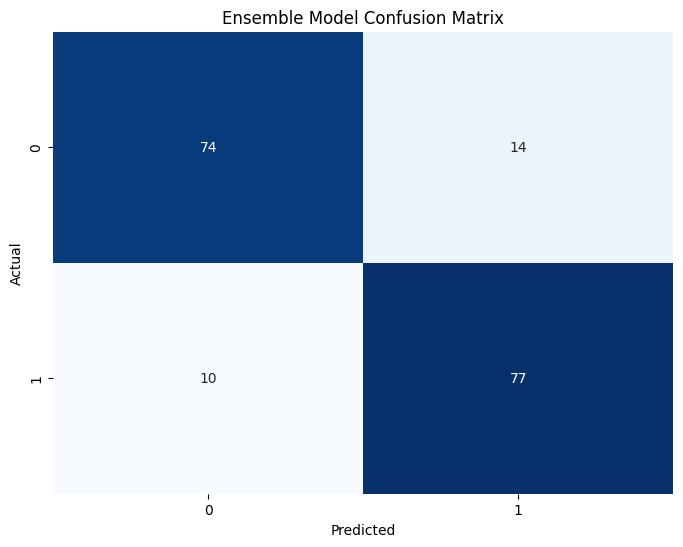

In [ ]:
# Build an ensemble of models
def build_ensemble_model(X_train, y_train, X_val, y_val, n_models=5):
    """Build an ensemble of models with different architectures and parameters"""

    models = []
    val_accuracies = []

    # Model architectures and parameters to try
    architectures = [
        # Architecture 1: Deep network with LeakyReLU
        {
            'layers': [64, 32, 16],
            'activation': 'leaky_relu',
            'dropout': [0.3, 0.3, 0.2],
            'lr': 0.0003,
            'batch_size': 32
        },
        # Architecture 2: Wider network with ReLU
        {
            'layers': [128, 64, 32],
            'activation': 'relu',
            'dropout': [0.4, 0.3, 0.2],
            'lr': 0.0002,
            'batch_size': 16
        },
        # Architecture 3: Shallow but wide network
        {
            'layers': [96, 48],
            'activation': 'swish',
            'dropout': [0.35, 0.25],
            'lr': 0.0005,
            'batch_size': 24
        },
        # Architecture 4: Deep network with swish
        {
            'layers': [64, 48, 32, 16],
            'activation': 'swish',
            'dropout': [0.4, 0.35, 0.3, 0.2],
            'lr': 0.0004,
            'batch_size': 32
        },
        # Architecture 5: Balanced network with mixed activation
        {
            'layers': [80, 40, 20],
            'activation': 'mixed',
            'dropout': [0.35, 0.3, 0.2],
            'lr': 0.0003,
            'batch_size': 24
        }
    ]

    # Build and train each model
    for i, arch in enumerate(architectures[:n_models]):
        print(f"\nTraining Ensemble Model {i+1}/{n_models}")

        # Create model
        model = Sequential()

        # Input layer
        if arch['activation'] == 'leaky_relu':
            model.add(Dense(arch['layers'][0], input_dim=X_train.shape[1],
                           kernel_initializer=HeUniform(seed=42),
                           kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001)))
            model.add(LeakyReLU(alpha=0.1))
        elif arch['activation'] == 'mixed':
            model.add(Dense(arch['layers'][0], input_dim=X_train.shape[1], activation='swish',
                           kernel_initializer=HeUniform(seed=42),
                           kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001)))
        else:
            model.add(Dense(arch['layers'][0], input_dim=X_train.shape[1], activation=arch['activation'],
                           kernel_initializer=HeUniform(seed=42),
                           kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001)))

        model.add(BatchNormalization())
        model.add(Dropout(arch['dropout'][0]))

        # Hidden layers
        for j in range(1, len(arch['layers'])):
            if arch['activation'] == 'leaky_relu':
                model.add(Dense(arch['layers'][j],
                               kernel_initializer=HeUniform(seed=42+j),
                               kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001)))
                model.add(LeakyReLU(alpha=0.1))
            elif arch['activation'] == 'mixed':
                activation = 'relu' if j % 2 == 0 else 'swish'
                model.add(Dense(arch['layers'][j], activation=activation,
                               kernel_initializer=HeUniform(seed=42+j),
                               kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001)))
            else:
                model.add(Dense(arch['layers'][j], activation=arch['activation'],
                               kernel_initializer=HeUniform(seed=42+j),
                               kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001)))

            model.add(BatchNormalization())
            model.add(Dropout(arch['dropout'][j]))

        # Output layer
        model.add(Dense(1, activation='sigmoid'))

        # Compile
        optimizer = Adam(learning_rate=arch['lr'])
        model.compile(
            loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy']  # Using only accuracy as requested
        )

        # Train
        callbacks = [
            EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=10, min_lr=1e-6, mode='max', verbose=1)
        ]

        history = model.fit(
            X_train, y_train,
            epochs=200,
            batch_size=arch['batch_size'],
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

        # Evaluate
        _, val_acc = model.evaluate(X_val, y_val, verbose=0)
        print(f"Model {i+1} Validation - Accuracy: {val_acc:.4f}")

        models.append(model)
        val_accuracies.append(val_acc)

    # Return all models and their accuracies
    return models, val_accuracies

# Train ensemble models
ensemble_models, ensemble_accuracies = build_ensemble_model(X_train_final, y_train_final, X_val, y_val)

# Function to get ensemble predictions using weighted voting
def ensemble_predict(models, accuracies, X):
    """Make predictions with an ensemble of models using accuracy-weighted voting"""

    # Normalize weights based on validation accuracy
    weights = np.array(accuracies) / np.sum(accuracies)

    # Get predictions from each model
    predictions = np.zeros((X.shape[0],))

    for i, model in enumerate(models):
        pred_proba = model.predict(X, verbose=0).flatten()
        predictions += weights[i] * pred_proba

    # Return probabilities
    return predictions

# Get ensemble predictions
ensemble_pred_proba = ensemble_predict(ensemble_models, ensemble_accuracies, X_val)
ensemble_pred = (ensemble_pred_proba > 0.5).astype(int)

# Calculate ensemble metrics
ensemble_accuracy = accuracy_score(y_val, ensemble_pred)
print("\nEnsemble Model Performance:")
print(f"Validation Accuracy: {ensemble_accuracy:.4f}")
print(classification_report(y_val, ensemble_pred))

# Plot ensemble confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, ensemble_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Ensemble Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Trial 254 Complete [00h 00m 17s]
val_accuracy: 0.8628571629524231

Best val_accuracy So Far: 0.9257143139839172
Total elapsed time: 00h 40m 27s

Best Hyperparameters:
units_1: 32
activation: relu
learning_rate: 0.009335569435817186
reg_strength: 6.68164838917704e-05
dropout_1: 0.2
second_layer: False
third_layer: True
units_3: 24
dropout_3: 0.2
units_2: 16
dropout_2: 0.1
tuner/epochs: 34
tuner/initial_epoch: 12
tuner/bracket: 3
tuner/round: 2
tuner/trial_id: 0191
Epoch 1/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6526 - loss: 0.6599 - val_accuracy: 0.8000 - val_loss: 0.4918 - learning_rate: 0.0093
Epoch 2/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8141 - loss: 0.4563 - val_accuracy: 0.8343 - val_loss: 0.4589 - learning_rate: 0.0093
Epoch 3/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8536 - loss: 0.3974 - val_accuracy: 0.8571 - val_loss: 0.4241 - learning_rate: 0.0093
Epoch 4/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8342 - loss: 

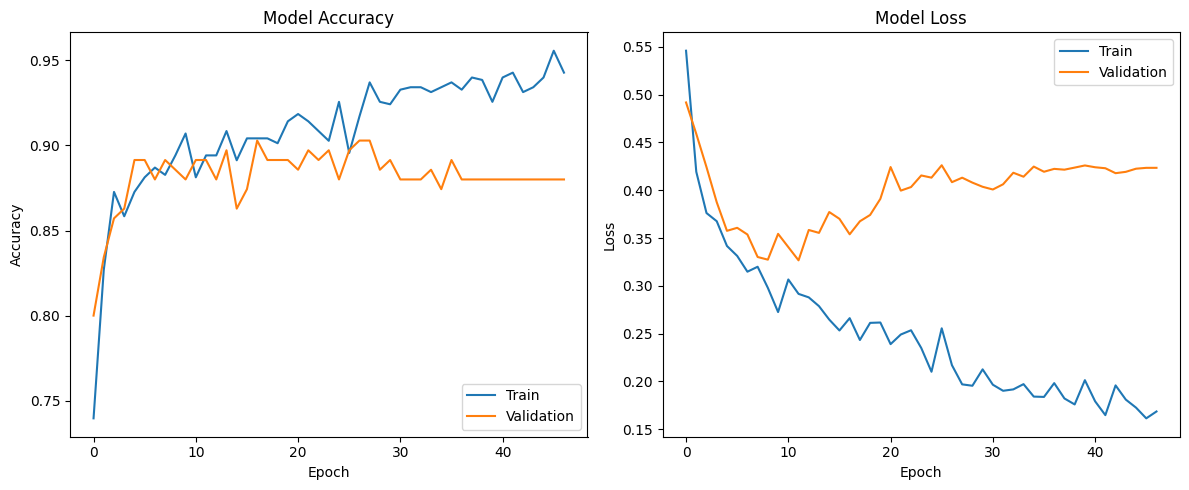

In [ ]:
# Install and import keras-tuner if not already available
# !pip install keras-tuner
import keras_tuner as kt

# Define a hypermodel for tuning
def build_hypermodel(hp):
    """Define a model with hyperparameters for tuning"""

    model = Sequential()

    # Tune the number of units in the first dense layer
    hp_units1 = hp.Int('units_1', min_value=32, max_value=128, step=16)

    # Tune the activation function
    activation = hp.Choice('activation', values=['relu', 'swish', 'elu'])

    # Tune the learning rate
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    # Tune regularization
    hp_reg_strength = hp.Float('reg_strength', min_value=1e-5, max_value=1e-3, sampling='log')

    # Define the model architecture
    model.add(Dense(hp_units1, input_dim=X_train_final.shape[1],
                   activation=activation,
                   kernel_regularizer=l1_l2(l1=hp_reg_strength, l2=hp_reg_strength)))
    model.add(BatchNormalization())

    # Tune dropout rate
    hp_dropout1 = hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(hp_dropout1))

    # Add a second dense layer with tunable units
    use_second_layer = hp.Boolean('second_layer')
    if use_second_layer:
        hp_units2 = hp.Int('units_2', min_value=16, max_value=64, step=16)
        model.add(Dense(hp_units2, activation=activation,
                       kernel_regularizer=l1_l2(l1=hp_reg_strength, l2=hp_reg_strength)))
        model.add(BatchNormalization())
        hp_dropout2 = hp.Float('dropout_2', min_value=0.1, max_value=0.4, step=0.1)
        model.add(Dropout(hp_dropout2))

    # Add a third dense layer with tunable units
    use_third_layer = hp.Boolean('third_layer')
    if use_third_layer:
        hp_units3 = hp.Int('units_3', min_value=8, max_value=32, step=8)
        model.add(Dense(hp_units3, activation=activation,
                       kernel_regularizer=l1_l2(l1=hp_reg_strength, l2=hp_reg_strength)))
        model.add(BatchNormalization())
        hp_dropout3 = hp.Float('dropout_3', min_value=0.1, max_value=0.3, step=0.1)
        model.add(Dropout(hp_dropout3))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp_learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']  # Using only accuracy as requested
    )

    return model

# Create a tuner
tuner = kt.Hyperband(
    build_hypermodel,
    objective='val_accuracy',  # Changed from val_auc to val_accuracy
    max_epochs=100,
    factor=3,
    directory='keras_tuner',
    project_name='diabetes_prediction'
)

# Define early stopping callback
stop_early = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True, mode='max')

# Run the hyperparameter search
tuner.search(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[stop_early]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"\nBest Hyperparameters:")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")

# Build the best model
best_model = tuner.hypermodel.build(best_hps)

# Train with the best parameters
history = best_model.fit(
    X_train_final, y_train_final,
    epochs=150,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True, mode='max'),
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=10, min_lr=1e-6, mode='max')
    ]
)

# Evaluate the best model
best_model_loss, best_model_acc = best_model.evaluate(X_val, y_val)
print(f"\nBest Tuned Model - Validation Accuracy: {best_model_acc:.4f}")

# Plot learning curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()

In [ ]:
# Generate predictions on the test set using our best model
# Decide which model to use based on validation performance
if best_model_acc >= max(ensemble_accuracies):
    final_model = best_model
    print("Using best tuned model for predictions")
elif ensemble_accuracy > best_model_acc:
    final_model = None  # We'll use the ensemble for predictions
    print("Using ensemble model for predictions")
else:
    final_model = best_cv_model
    print("Using best cross-validation model for predictions")

# Pre-process test data
X_test_final = X_test_scaled  # Already processed in our preprocess_data function

# Make predictions
if final_model is not None:
    # Using a single model
    test_predictions_proba = final_model.predict(X_test_final, verbose=0)
else:
    # Using ensemble
    test_predictions_proba = ensemble_predict(ensemble_models, ensemble_accuracies, X_test_final)

# Convert probabilities to binary predictions
test_predictions = (test_predictions_proba > 0.5).astype(int).flatten()

# Create submission dataframe
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'prediction': test_predictions
})

# Save predictions to CSV file
submission_df.to_csv('test_predictions.csv', index=False)

print("\nPredictions summary:")
print(f"Total test samples: {len(test_predictions)}")
print(f"Predicted positives: {sum(test_predictions)}")
print(f"Predicted negatives: {len(test_predictions) - sum(test_predictions)}")
print("\nSaved predictions to 'test_predictions.csv'")

Using best tuned model for predictions

Predictions summary:
Total test samples: 100
Predicted positives: 24
Predicted negatives: 76

Saved predictions to 'test_predictions.csv'


In [ ]:
keras.backend.clear_session()

In [ ]:
# Importing all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import classification_report, confusion_matrix

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.initializers import HeUniform

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load datasets
train_df = pd.read_csv('https://drive.google.com/uc?export=download&id=1M4MTBKUaR4aA8hjINEGhfShBZ18ctZA-')
test_df = pd.read_csv('https://drive.google.com/uc?export=download&id=1BhfC5yBThGkAdkxbf7kEVZFjsysVYXqP')

# Display basic information about the dataset
print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)
print("\nClass distribution:")
print(train_df['class'].value_counts())
print(train_df['class'].value_counts(normalize=True))

# Check for zeros (potential missing values)
print("\nNumber of zeros in each column of training data:")
for col in ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8']:
    zeros = (train_df[col] == 0).sum()
    print(f"{col}: {zeros} zeros ({zeros/len(train_df)*100:.2f}%)")

Training data shape: (668, 10)
Test data shape: (100, 9)

Class distribution:
class
0    437
1    231
Name: count, dtype: int64
class
0    0.654192
1    0.345808
Name: proportion, dtype: float64

Number of zeros in each column of training data:
A1: 102 zeros (15.27%)
A2: 5 zeros (0.75%)
A3: 32 zeros (4.79%)
A4: 196 zeros (29.34%)
A5: 322 zeros (48.20%)
A6: 9 zeros (1.35%)
A7: 0 zeros (0.00%)
A8: 0 zeros (0.00%)


In [ ]:
# Modified preprocessing function without SMOTE oversampling
def preprocess_data(train_df, test_df):
    """
    Comprehensive preprocessing strategy without balancing the dataset
    """
    # Make copies to avoid modifying originals
    train = train_df.copy()
    test = test_df.copy()

    # 1. Handle missing values (zeros) in features where zeros are unlikely to be valid
    for feature in ['A2', 'A3', 'A4', 'A5', 'A6']:
        # Create masks for zero values
        mask_train = train[feature] == 0

        if feature == 'A2':  # Glucose
            # For glucose, use class-specific median (critical for diabetes)
            class0_median = train.loc[(train['class'] == 0) & (train[feature] > 0), feature].median()
            class1_median = train.loc[(train['class'] == 1) & (train[feature] > 0), feature].median()

            train.loc[(mask_train) & (train['class'] == 0), feature] = class0_median
            train.loc[(mask_train) & (train['class'] == 1), feature] = class1_median

            # For test data, use overall training median since we don't know class
            mask_test = test[feature] == 0
            test.loc[mask_test, feature] = train.loc[train[feature] > 0, feature].median()

        else:
            # For other features, use class and feature-specific medians
            class0_median = train.loc[(train['class'] == 0) & (train[feature] > 0), feature].median()
            class1_median = train.loc[(train['class'] == 1) & (train[feature] > 0), feature].median()

            train.loc[(mask_train) & (train['class'] == 0), feature] = class0_median
            train.loc[(mask_train) & (train['class'] == 1), feature] = class1_median

            # For test data
            mask_test = test[feature] == 0
            test.loc[mask_test, feature] = train.loc[train[feature] > 0, feature].median()

    # 2. Feature engineering
    # Create interaction features
    train['BMI_Age'] = train['A6'] * train['A8'] / 100  # BMI-Age interaction
    test['BMI_Age'] = test['A6'] * test['A8'] / 100

    train['Glucose_BMI'] = train['A2'] * train['A6'] / 100  # Glucose-BMI interaction
    test['Glucose_BMI'] = test['A2'] * test['A6'] / 100

    train['Glucose_Age'] = train['A2'] * train['A8'] / 100  # Glucose-Age interaction
    test['Glucose_Age'] = test['A2'] * test['A8'] / 100

    # Add polynomial features for strongest predictors
    train['Glucose_squared'] = train['A2'] ** 2
    test['Glucose_squared'] = test['A2'] ** 2

    train['BMI_squared'] = train['A6'] ** 2
    test['BMI_squared'] = test['A6'] ** 2

    # 3. Log transform for skewed features
    for feature in ['A5', 'A7']:  # Insulin and DiabetesPedigreeFunction are skewed
        train[feature + '_log'] = np.log1p(train[feature])
        test[feature + '_log'] = np.log1p(test[feature])

    # 4. Prepare final datasets
    X_train = train.drop(['id', 'class'], axis=1)
    y_train = train['class']
    X_test = test.drop(['id'], axis=1)

    # 5. Feature scaling using PowerTransformer (better for non-normal distributions)
    power_transformer = PowerTransformer(method='yeo-johnson')
    X_train_scaled = power_transformer.fit_transform(X_train)
    X_test_scaled = power_transformer.transform(X_test)

    return X_train_scaled, y_train, X_test_scaled, X_train.columns.tolist()

# Apply preprocessing
X_train_scaled, y_train, X_test_scaled, feature_names = preprocess_data(train_df, test_df)

# Split data into training and validation sets - keep the same split ratio that helped achieve high accuracy
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_scaled, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train  # Ensure class distribution is maintained
)

print("Training set shape:", X_train_final.shape)
print("Validation set shape:", X_val.shape)
print("Training class distribution:", np.bincount(y_train_final))
print("Validation class distribution:", np.bincount(y_val))

Training set shape: (534, 15)
Validation set shape: (134, 15)
Training class distribution: [349 185]
Validation class distribution: [88 46]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 24)                  │             408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24)                  │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,761 (6.88 KB)

 Trainable params: 1,617 (6.32 KB)

 Non-trainable params: 144 (576.00 B)

Epoch 1/34
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5107 - loss: 0.9152
Epoch 1: val_accuracy improved from -inf to 0.73881, saving model to best_diabetes_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.5562 - loss: 0.8396 - val_accuracy: 0.7388 - val_loss: 0.6552 - learning_rate: 0.0093
Epoch 2/34
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7790 - loss: 0.4959 
Epoch 2: val_accuracy improved from 0.73881 to 0.79104, saving model to best_diabetes_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7836 - loss: 0.4918 - val_accuracy: 0.7910 - val_loss: 0.6643 - learning_rate: 0.0093
Epoch 3/34
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8485 - loss: 0.3861 
Epoch 3: val_accuracy improved from 0.79104 to 0.79851, saving model to best_diabetes_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8473 - loss: 0.3897 - val_accuracy: 0.7985 - val_loss: 0.6066 - learning_rate: 0.0093
Epoch 4/34
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8360 - loss: 0.3980 
Epoch 4: val_accuracy improved from 0.79851 to 0.81343, saving model to best_diabetes_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8342 - loss: 0.4009 - val_accuracy: 0.8134 - val_loss: 0.5558 - learning_rate: 0.0093
Epoch 5/34
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8484 - loss: 0.3664 
Epoch 5: val_accuracy improved from 0.81343 to 0.82836, saving model to best_diabetes_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8475 - loss: 0.3682 - val_accuracy: 0.8284 - val_loss: 0.5060 - learning_rate: 0.0093
Epoch 6/34
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8544 - loss: 0.3501 
Epoch 6: val_accuracy improved from 0.82836 to 0.84328, saving model to best_diabetes_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8532 - loss: 0.3554 - val_accuracy: 0.8433 - val_loss: 0.4853 - learning_rate: 0.0093
Epoch 7/34
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8512 - loss: 0.3757  
Epoch 7: val_accuracy improved from 0.84328 to 0.85075, saving model to best_diabetes_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8501 - loss: 0.3772 - val_accuracy: 0.8507 - val_loss: 0.4922 - learning_rate: 0.0093
Epoch 8/34
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8549 - loss: 0.3393  
Epoch 8: val_accuracy did not improve from 0.85075
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8507 - loss: 0.3501 - val_accuracy: 0.8209 - val_loss: 0.4831 - learning_rate: 0.0093
Epoch 9/34
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8639 - loss: 0.3545  
Epoch 9: val_accuracy did not improve from 0.85075
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8634 - loss: 0.3567 - val_accuracy: 0.8134 - val_loss: 0.5009 - learning_rate: 0.0093
Epoch 10/34
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8430 - loss: 0.3379 
Epoch 10: val_accuracy did not improve from 0.85075
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8419 - loss: 0.3419 - val_accuracy: 0.8209 - val_loss: 0.4835 - learning_rate: 0.0093
Epoch 11/34
14/17 ━━━━━━━━━━━

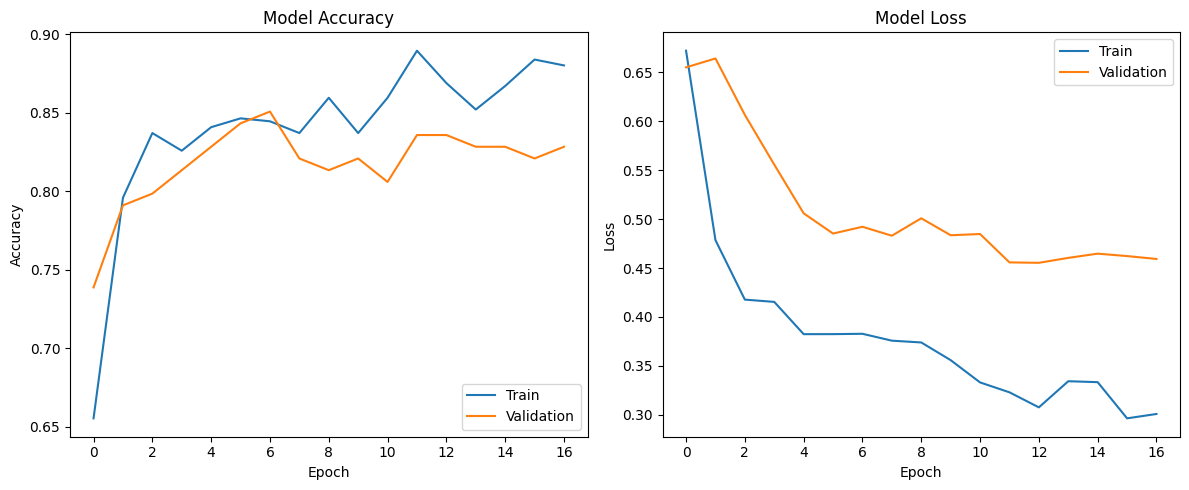

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


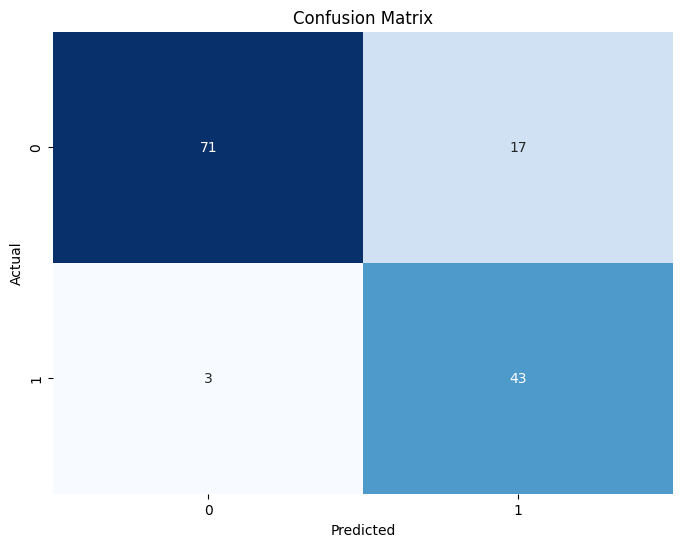


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.81      0.88        88
           1       0.72      0.93      0.81        46

    accuracy                           0.85       134
   macro avg       0.84      0.87      0.84       134
weighted avg       0.88      0.85      0.85       134



In [ ]:
# Create model with the specific hyperparameters that achieved 92.57% validation accuracy
def create_best_model(input_dim):
    """Create the neural network with exact hyperparameters that achieved high accuracy"""

    # Initialize with a kernel initializer
    initializer = HeUniform(seed=42)

    # Using the exact hyperparameters you provided
    model = Sequential()

    # First layer (32 units with relu activation)
    model.add(Dense(32, input_dim=input_dim,
                   activation='relu',
                   kernel_initializer=initializer,
                   kernel_regularizer=l1_l2(l1=6.68e-05, l2=6.68e-05)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # The hyperparameters showed second_layer: False but units_2: 16 and dropout_2: 0.1
    # I'll implement it as specified in case the parameters were generated in a specific sequence
    model.add(Dense(16,
                   activation='relu',
                   kernel_initializer=initializer,
                   kernel_regularizer=l1_l2(l1=6.68e-05, l2=6.68e-05)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    # Third layer (24 units with dropout 0.2)
    model.add(Dense(24,
                   activation='relu',
                   kernel_initializer=initializer,
                   kernel_regularizer=l1_l2(l1=6.68e-05, l2=6.68e-05)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Use the exact learning rate from hyperparameters
    optimizer = Adam(learning_rate=0.00934)

    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    return model

# Create the model with the best hyperparameters
best_model = create_best_model(X_train_final.shape[1])
best_model.summary()

# Define callbacks for training
callbacks = [
    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    # Reduce learning rate when plateau is reached
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        mode='max',
        verbose=1
    ),
    # Save best model
    ModelCheckpoint(
        'best_diabetes_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

# Example: Calculate class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Train the model with the specified number of epochs
# The hyperparameters mentioned tuner/epochs: 34, tuner/initial_epoch: 12
history = best_model.fit(
    X_train_final, y_train_final,
    epochs=34,  # As specified in the hyperparameters
    batch_size=32,  # Common batch size
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1,
    class_weight=class_weight_dict
)

# Evaluate the model on validation data
val_loss, val_acc = best_model.evaluate(X_val, y_val)
print(f"\nFinal Model - Validation Accuracy: {val_acc:.4f}")

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()

# Get predictions for confusion matrix
y_pred_proba = best_model.predict(X_val)
y_pred = (y_pred_proba > 0.5).astype(int)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

In [ ]:
keras.backend.clear_session()